#Detección de ADHD a partir de señales de EEG mediante el uso de Aprendizaje Automático

*   María Emilia Gáspari 61045
*   Francesca Rondinella 61031
*   Guadalupe Varela 61060







# Introducción

## ADHD
<p align = "justify"> El Trastorno por Déficit de Atención con Hiperactividad (o ADHD, por sus siglas en inglés) es una condición crónica que afecta la capacidad para prestar atención, impulsividad e inquietud. Sus síntomas oscilan de leves a graves, y pueden conllevar problemas para relacionarse, desempeños laborales o académicos negativos y baja autoestima, entre otros. Por este motivo, es de vital importancia la detección del ADHD, para poder tratarlo (a través de fármacos y psicoterapia, entre otros) y colaborar a la normalidad de la vida del paciente.</p>

<p align = "justify"> Se estima que, globalmente, alrededor de un 5% de los niños y adolescentes padecen de ADHD. En adultos se tiene una cifra similar, aunque existe cierto debate acerca de los criterios de diagnóstico para dicho grupo etario.</p>


## Diagnóstico
<p align = "justify"> Normalmente, el diagnóstico se basa en evaluaciones realizadas por médicos calificados y especialistas en psiquiatría. Los exámenes incluyen revisiones físicas y psicológicas, que sirven para descartar otros trastornos que puedan estar causando los síntomas, como depresión, ansiedad o abuso de sustancias.</p>

<p align = "justify"> Actualmente existen numerosas publicaciones acerca de la identificación de ADHD a partir de exámenes como el electroencefalograma (EEG), y es una cuestión que continúa bajo investigación. En líneas generales, se buscan patrones en dichas señales que se correlacionen con la presencia del trastorno. Estos varían desde una disminución en la potencia de los ritmos theta, hasta una correlación con la dimensión fractal.</p>

<p align = "justify"> El presente trabajo práctico tiene como objetivo la aplicación de técnicas de procesamiento de señales y de aprendizaje automático para predecir la presencia de ADHD a partir de muestras de EEG. Se trata de un problema de clasificación con dos resultados posibles: 1 para personas que sufren ADHD y 0 para aquellas que no.</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install spkit
! pip install antropy
! pip install nolds
! pip install tensorpac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 30.1 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.5-py3-none-any.whl size=16897 sha256=a10b6c62618e148d8e6d75295c2518f55095fcb9c03a09dd0f3a1839d7720045
  Stored in directory: /root/.cache/pip/wheels/82/7e/6b/683a215d168d889bb7917d1e571174201e89c7b9c2d86b981e
Successfully built antropy
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy

In [ ]:
import scipy.io
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import sosfiltfilt, butter, iirnotch, welch
import random
import antropy as ant
import nolds
import spkit as spk

In [ ]:
#bibliotecas de ML
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingRandomSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import randint, uniform

# Señal de EEG cruda

<p align = "justify"> A continuación se importan 121 archivos que corresponden a los registros de EEG efectuados durante una prueba de atención visual. . De estos, 61 registros corresponden a sujetos con ADHD y 60 a sujetos sin ADHD. Los sujetos son niños y niñas de 7 a 12 años sin historial de epilepsia, trastornos psiquiátricos y otras condiciones que pudieran afectar el resultado de la prueba. Además, todos los niños que padecen de ADHD estaban bajo tratamiento farmacológico desde hace a lo sumo seis meses.

La tarea consistía en mostrar en una pantalla de 5 a 16 personajes de caricaturas, que los niños debían contar. La muestra inicia cuando comienza la prueba y termina al finalizarse la misma. Por lo tanto, la duración guarda relación con la performance.

Cada uno de los archivos contiene señales de 19 canales de EEG, muestreadas a una frecuencia de 128 Hz.<p>

Los registros fueron obtenidos a partir del siguiente [dataset](https://https://ieee-dataport.org/open-access/eeg-data-adhd-control-children)


![eeg_map.jpg](https://drive.google.com/uc?export=view&id=1NRFgHfvLY6B4yMEFHtaDhQ3T1Bv4-CyP)

| Columna | Canal |
|---------|:-------|
| 1 |  Fp1 |        
| 2 |  Fp2 |
| 3 |  F3 |
| 4 |  F4 |
| 5 |  C3 |
| 6 |  C4 |
| 7 |  P3 |
| 8 |  P4 |
| 9 |  O1 |
| 10 |  O2 |
| 11 |  F7 |
| 12 |  F8 |
| 13 |  T7 |
| 14 |  T8 |
| 15 |  P7 |
| 16 |  P8 |
| 17 |  Fz |
| 18 |  Cz |
| 19 |  Pz | 




In [ ]:
canales=['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']

In [ ]:
path1='/content/drive/MyDrive/PSB final/Datos/ADHD'
path2='/content/drive/MyDrive/PSB final/Datos/Control'

ADHD=os.listdir(path1)
CTRL=os.listdir(path2)


print(len(ADHD))
print(len(CTRL))

61
60


In [ ]:
#levanto los archivos .mat
ADHD_data=[]
for i in range(len(ADHD)):
  ADHD_data.append(scipy.io.loadmat(path1+'/'+ADHD[i])[os.path.splitext(ADHD[i])[0]])

CTRL_data=[]
for i in range(len(CTRL)):
  CTRL_data.append(scipy.io.loadmat(path2+'/'+CTRL[i])[os.path.splitext(CTRL[i])[0]])

<p align = "justify"> Se puede ver que los registros tienen 19 columnas, correspondientes a los 19 canales, y una cantidad variable de filas que corresponde a la cantidad de muestras tomadas durante la prueba. Este último parámetro dependerá entonces del tiempo que le llevo a cada sujeto completar la prueba.</p>

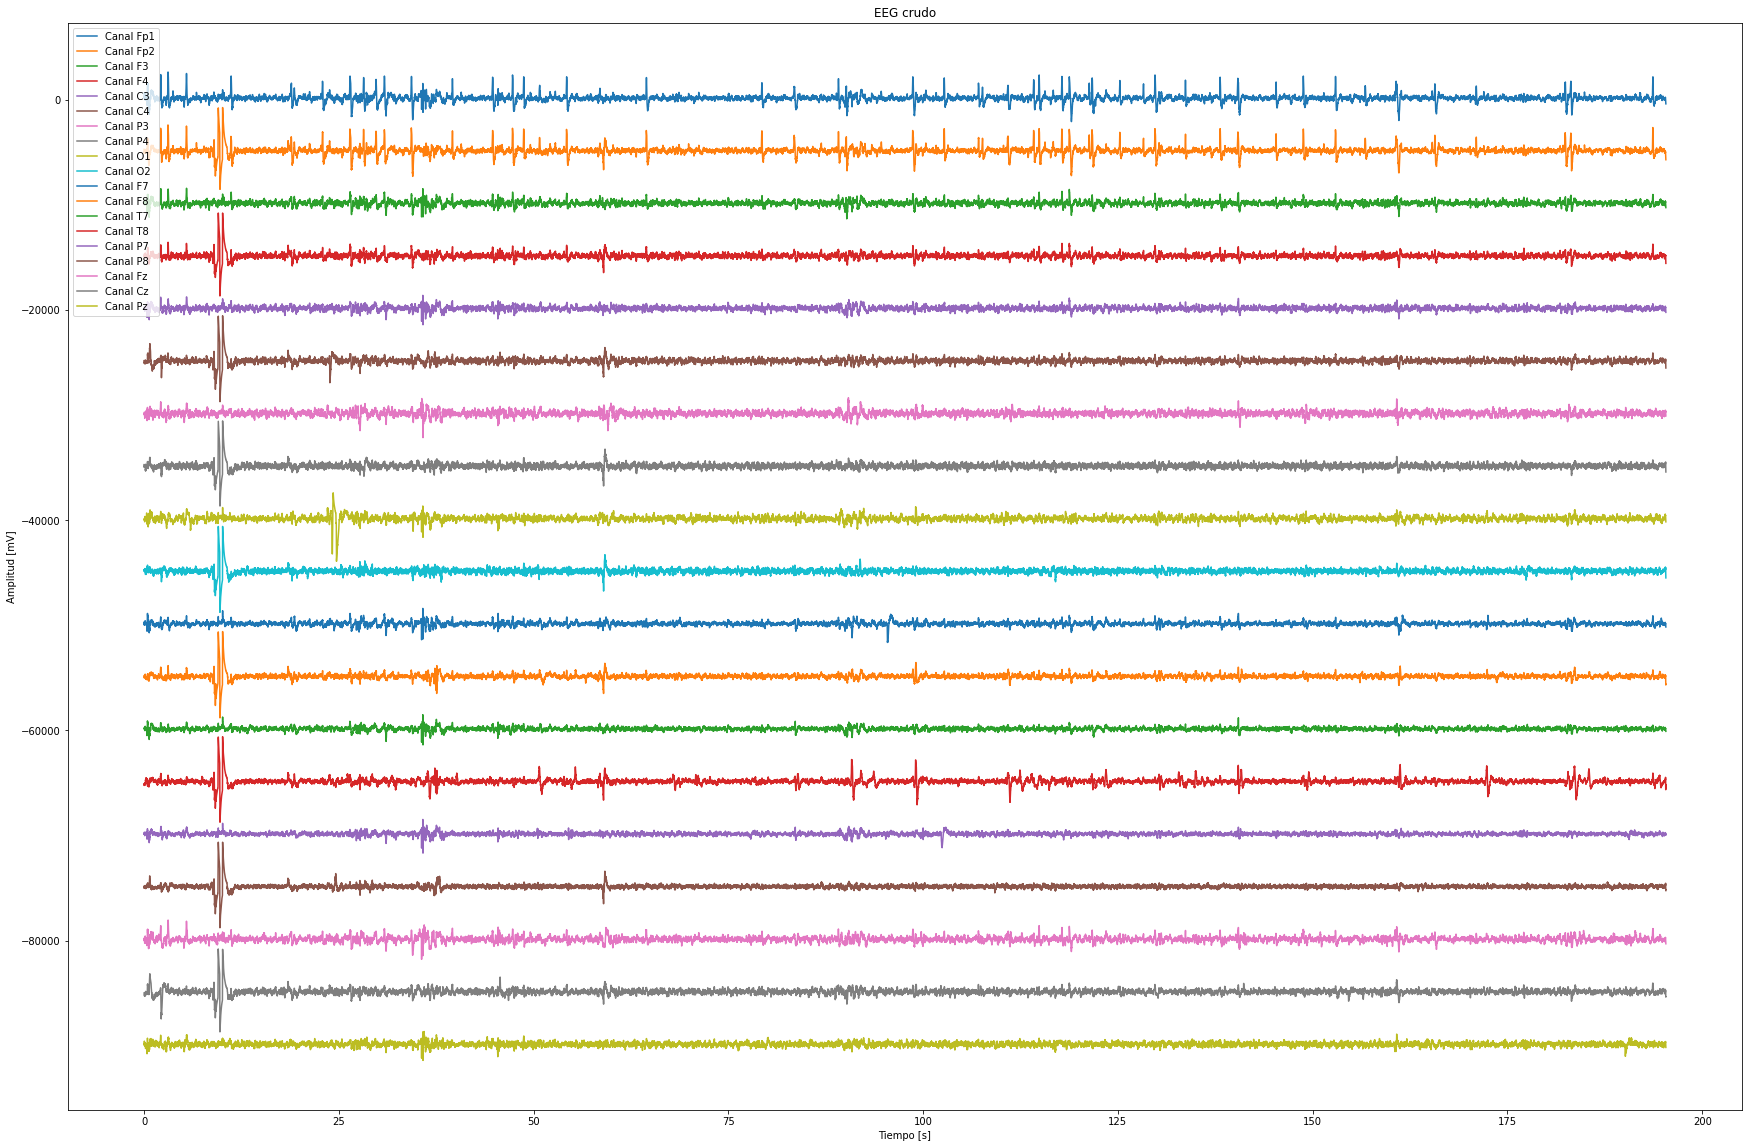

In [ ]:
fs = 128

def grafico_prueba(signal, fs, titulo):
  plt.figure(figsize=(30,20))

  for i in range(len(signal)):
    t1=np.arange(0,len(signal[i])/fs,1/fs)
    plt.plot(t1, signal[i]-i*5000, label='Canal '+canales[i])
    plt.ylabel('Amplitud [mV]')
    plt.xlabel('Tiempo [s]')
    plt.title(titulo)

  plt.legend()
  plt.show()

grafico_prueba(ADHD_data[6].T, fs, 'EEG crudo')


In [ ]:
print(np.shape(ADHD_data[0]))
print(np.shape(CTRL_data[0]))

(24695, 19)
(10871, 19)


A continuación se muestra el espectrograma de una persona con ADHD y el de una persona sin.

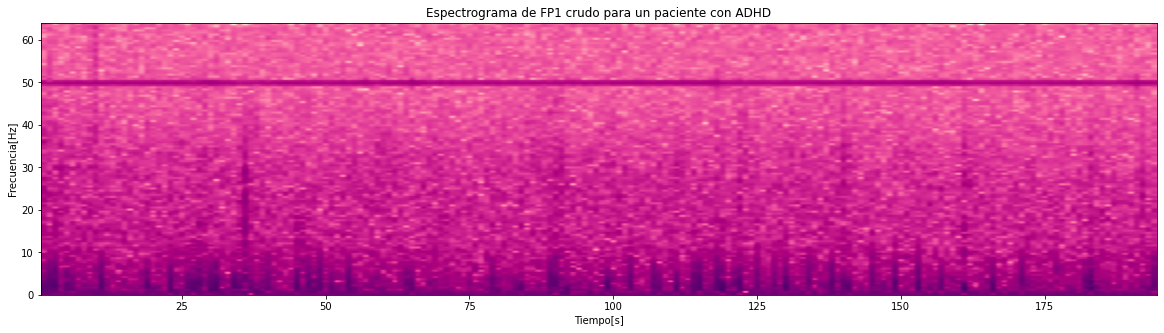

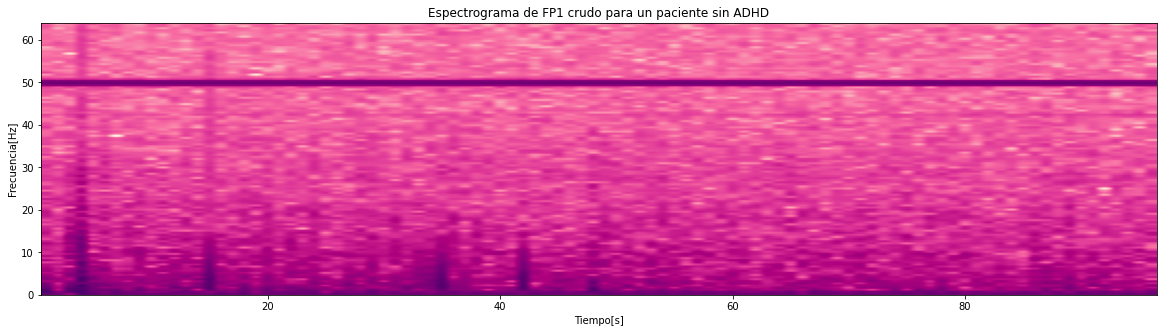

In [ ]:

plt.figure(figsize = (20,5))
_ = plt.specgram(ADHD_data[6][:,0], Fs=fs, cmap='RdPu')
t=np.arange(0,len(ADHD_data[6][:,0])/fs,1/fs)
plt.ylim(0,64)
plt.xlabel('Tiempo[s]')
plt.ylabel('Frecuencia[Hz]')
plt.title('Espectrograma de FP1 crudo para un paciente con ADHD')
plt.show()

plt.figure(figsize = (20,5))
_ = plt.specgram(CTRL_data[6][:,0], Fs=fs, cmap='RdPu')
t=np.arange(0,len(CTRL_data[6][:,0])/fs,1/fs)
plt.ylim(0,64)
plt.xlabel('Tiempo[s]')
plt.ylabel('Frecuencia[Hz]')
plt.title('Espectrograma de FP1 crudo para un paciente sin ADHD')
plt.show()

# Acondicionamiento de la señal

<p align = "justify"> Antes de comenzar a trabajar con la señal de EEG en el algoritmo de Machine Learning es necesario acondicianarla. </p>

## Ruido de línea

<p align = "justify">En principio, se filtra el ruido de línea de la señal mediante un filtro Butterworth rechaza-banda de orden 4 con frecuencia de corte 50 Hz.</p>

In [ ]:
def RL(signal,fs):
  wn=[49,51]
  filtro = butter(4, wn, btype = 'bandstop', output ='sos', fs=fs)
  j=sosfiltfilt(filtro ,signal, axis=-1)
  return j

In [ ]:
#Filtrado del ruido de linea

def filtrar_RL(signal, fs):
  signal_RL=[]
  for j in range(len(signal)):
    sujeto=[]
    for i in range(19):
      canal=RL(signal[j][:,i],fs)
      sujeto+=[canal]
    signal_RL+=[sujeto]
  return signal_RL

ADHD_RL=filtrar_RL(ADHD_data, fs)
CTRL_RL=filtrar_RL(CTRL_data, fs)

A modo de ejemplo se tomó un espectrograma para mostrar que se logra filtrar efectivamente el ruido de línea.

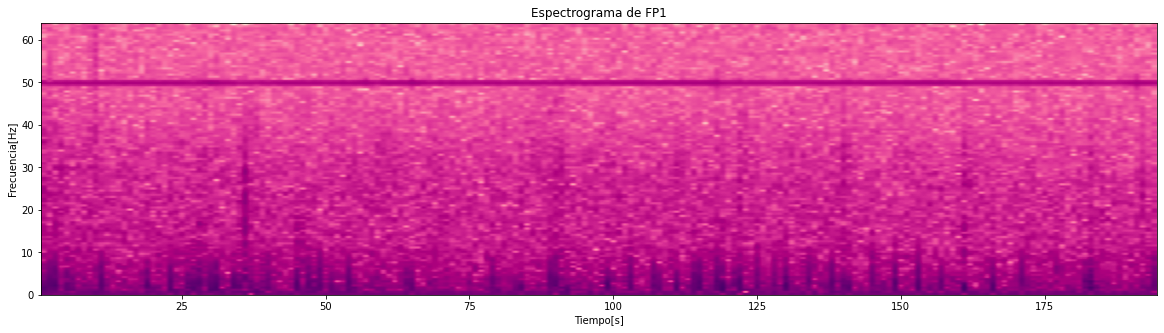

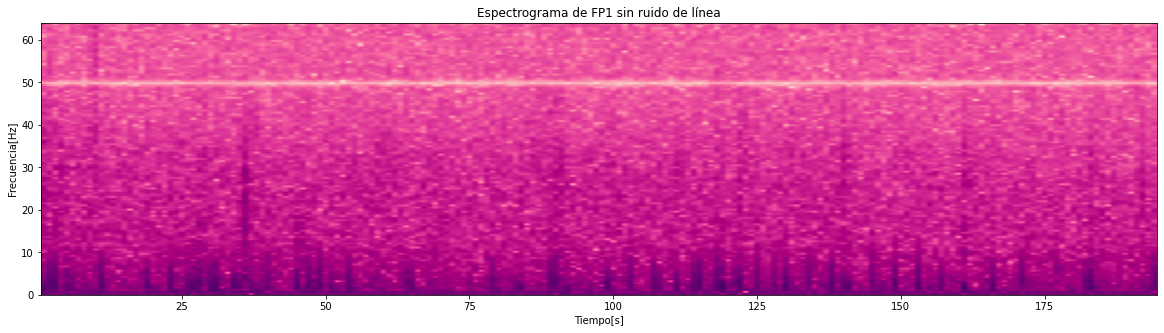

In [ ]:
#espectrograma

plt.figure(figsize = (20,5))
_ = plt.specgram(ADHD_data[6][:,0], Fs=fs, cmap='RdPu')
t=np.arange(0,len(ADHD_data[6][:,0])/fs,1/fs)
plt.ylim(0,64)
plt.xlabel('Tiempo[s]')
plt.ylabel('Frecuencia[Hz]')
plt.title('Espectrograma de FP1')
plt.show()

plt.figure(figsize = (20,5))
_ = plt.specgram(ADHD_RL[6][0], Fs=fs, cmap='RdPu')
t=np.arange(0,len(ADHD_RL[6][0])/fs,1/fs)
plt.ylim(0,64)
plt.xlabel('Tiempo[s]')
plt.ylabel('Frecuencia[Hz]')
plt.title('Espectrograma de FP1 sin ruido de línea')
plt.show()

## Ruido de alta frecuencia

En un principio, se filtraron los ruidos de alta frecuencia con un filtro Butterworth pasa-bajos de orden 4, tomando como frecuencia de corte los 60 Hz (considerando que en vigilia se tienen frecuencias de a lo sumo aproximadamente 30 Hz). Sin embargo, se observó que en numerosas muestras no había grandes diferencias entre la señal original y aquella filtrada. A modo de ejemplo se halla un espectrograma a continuación. Una explicación posible es la frecuencia de muestreo tomada (128 Hz), que implica un alcance de hasta 64 Hz para los registros.

In [ ]:
def LP(sig,fs):
  N = 4
  wn = 60 #última frec de ritmos cerebrales
  filtro = butter(N, wn, btype = 'lowpass', fs = fs, output='sos')
  sig_LP = sosfiltfilt(filtro,sig, axis =0)
  return sig_LP

In [ ]:
def filtrar_HF(signal, fs):
  signal_HF=[]
  for j in range(len(signal)):
    sujeto=[]
    for i in range(19):
      canal=LP(signal[j][i],fs)
      sujeto+=[canal]
    signal_HF+=[sujeto]
  return signal_HF

ADHD_HF=filtrar_HF(ADHD_RL, fs)
CTRL_HF=filtrar_HF(CTRL_RL, fs)

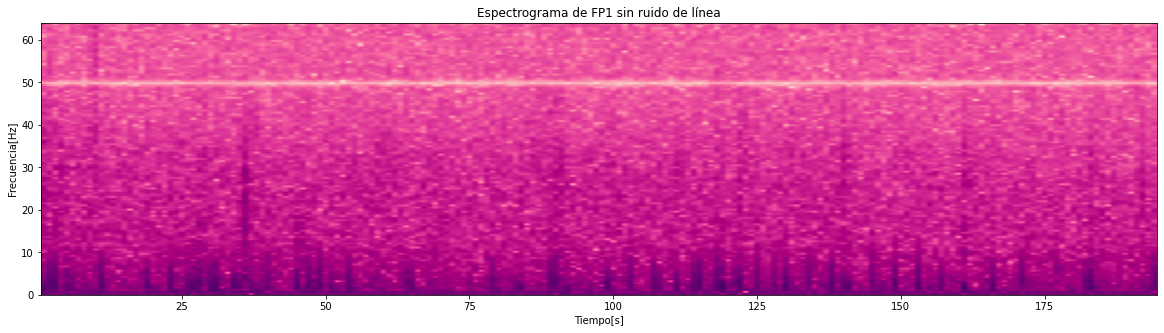

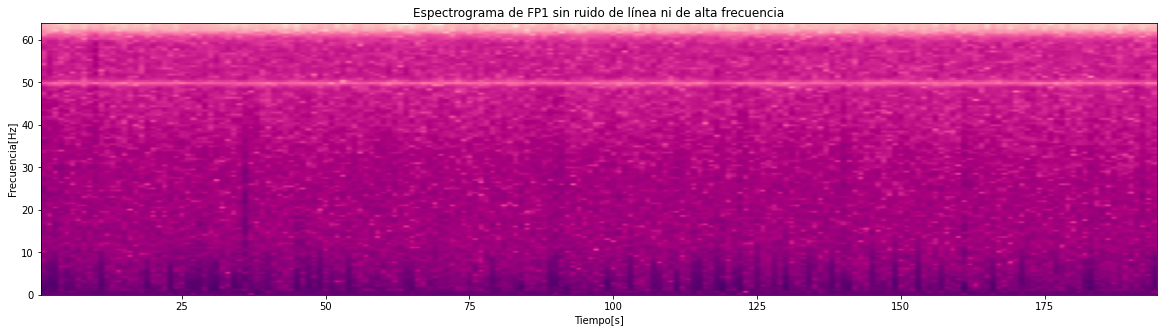

In [ ]:
#espectrograma

plt.figure(figsize = (20,5))
_ = plt.specgram(ADHD_RL[6][0], Fs=fs, cmap='RdPu')
t=np.arange(0,len(ADHD_RL[6][0])/fs,1/fs)
plt.ylim(0,64)
plt.xlabel('Tiempo[s]')
plt.ylabel('Frecuencia[Hz]')
plt.title('Espectrograma de FP1 sin ruido de línea')
plt.show()

plt.figure(figsize = (20,5))
_ = plt.specgram(ADHD_HF[6][0], Fs=fs, cmap='RdPu')
t=np.arange(0,len(ADHD_HF[6][0])/fs,1/fs)
plt.ylim(0,64)
plt.xlabel('Tiempo[s]')
plt.ylabel('Frecuencia[Hz]')
plt.title('Espectrograma de FP1 sin ruido de línea ni de alta frecuencia')
plt.show()

## Ruido de deriva

<p align = "justify"> Además, se quita el ruido de deriva con un Butterworth pasa-altos de orden 2, con frecuencia de corte 0.1 Hz (Cañadas et al., 2018).</p>

In [ ]:
def HP(sig,fs):
  N = 2**1
  wn = 0.1
  filtro = butter(N, wn, btype = 'highpass', fs = fs, output='sos')
  sig_HP = sosfiltfilt(filtro,sig, axis = 0)
  return sig_HP

In [ ]:
#Filtrado de ruido de deriva
def filtrar_RD(signal, fs):
  signal_RD=[]
  for j in range(len(signal)):
    sujeto=[]
    for i in range(19):
      canal=HP(signal[j][i],fs)
      sujeto+=[canal]
    signal_RD+=[sujeto]
  return signal_RD

ADHD_RD=filtrar_RD(ADHD_RL, fs)
CTRL_RD=filtrar_RD(CTRL_RL, fs)

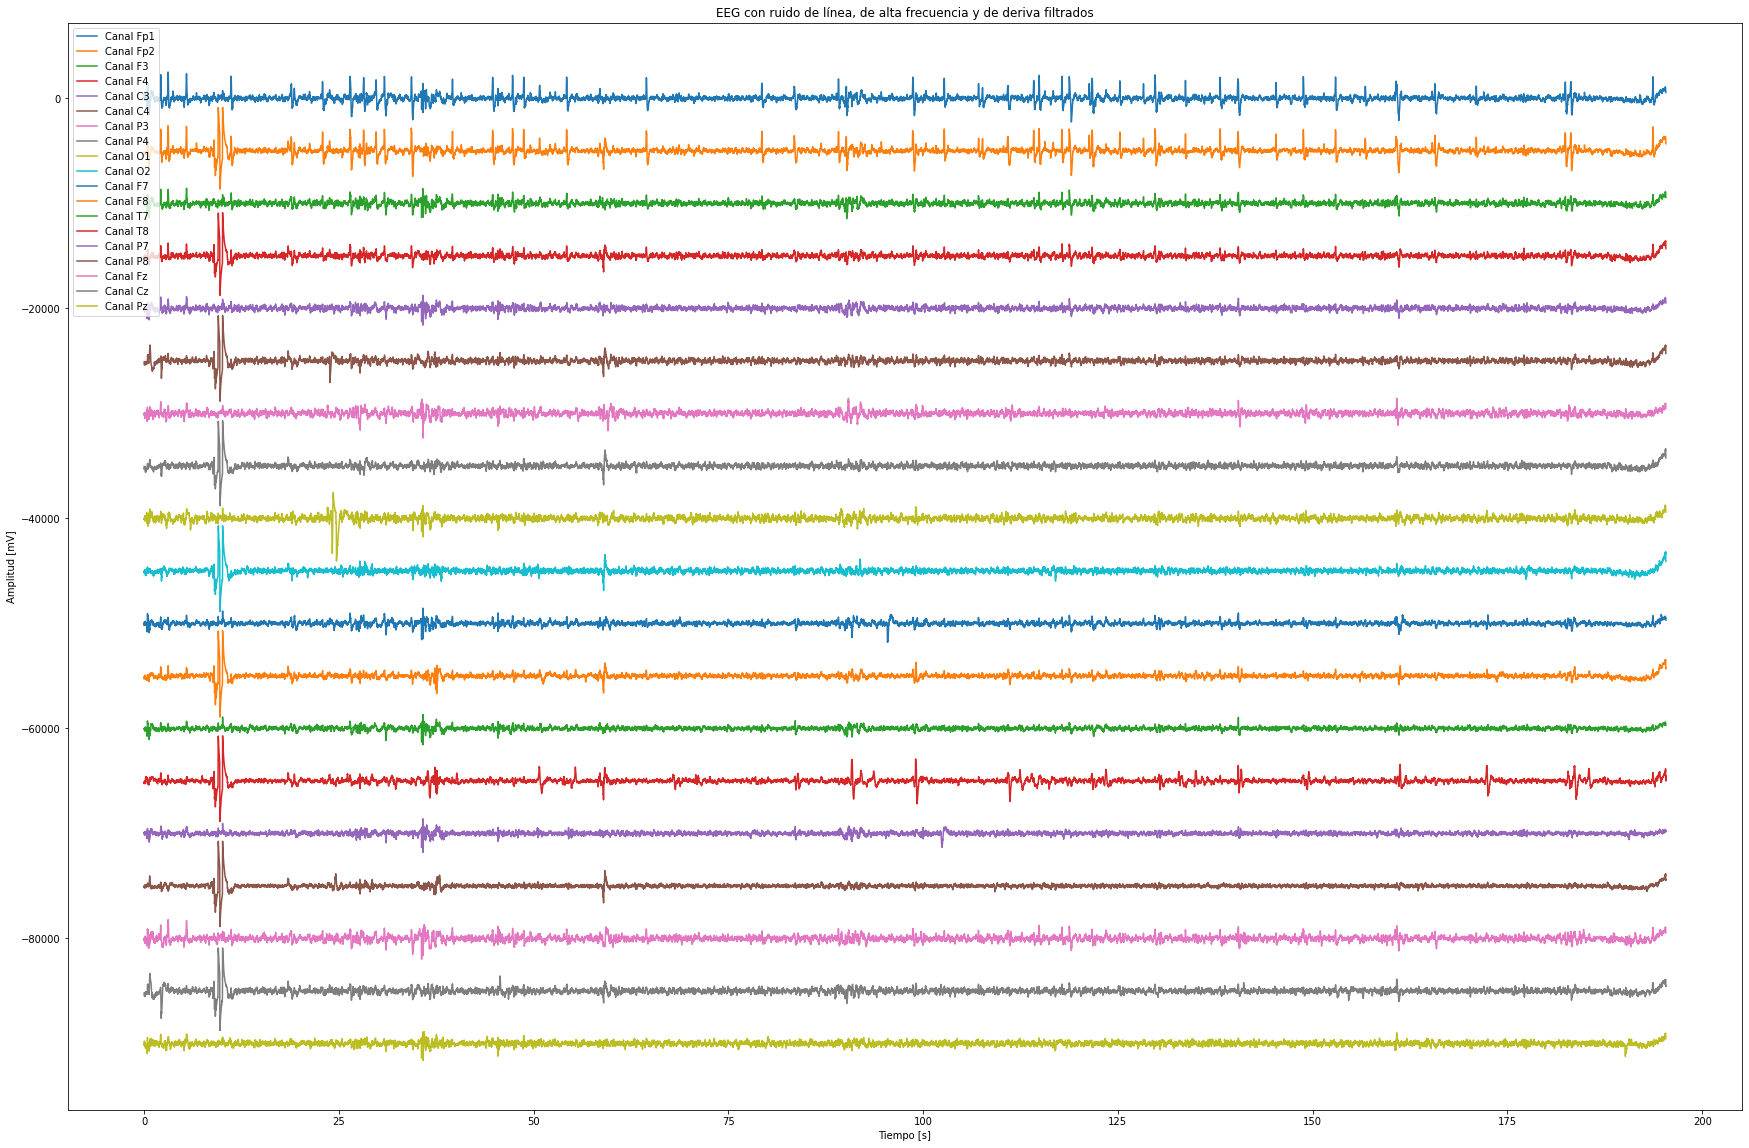

In [ ]:
grafico_prueba(ADHD_RD[6], fs, 'EEG con ruido de línea, de alta frecuencia y de deriva filtrados')

## Ruido de EOG

<p align = "justify">Puesto que no se registraron señales de electrooculograma (EOG), es necesario recurrir a algún método capaz de estimarlas para así eliminarlas. Para esta finalidad se utilizó el denominado <i>Automatic and Tunable Artifact Removal Algorithm</i> (o ATAR). El mismo se basa en wavelet packet decomposion (WPD). 

Como puede verse en el diagrama en bloques a continuación, se inicia con un filtro pasa-altos con frecuencia de corte 0,5Hz, seguido de una descomposición en paquetes de wavelets. Luego, se procede al filtrado según el método de eliminación. Simplemente se eliminan los componentes que superen un cierto umbral, asumiendo que contienen solo información de artefactos.</p>

Luego, se recompone la señal realizando una transformada inversa.

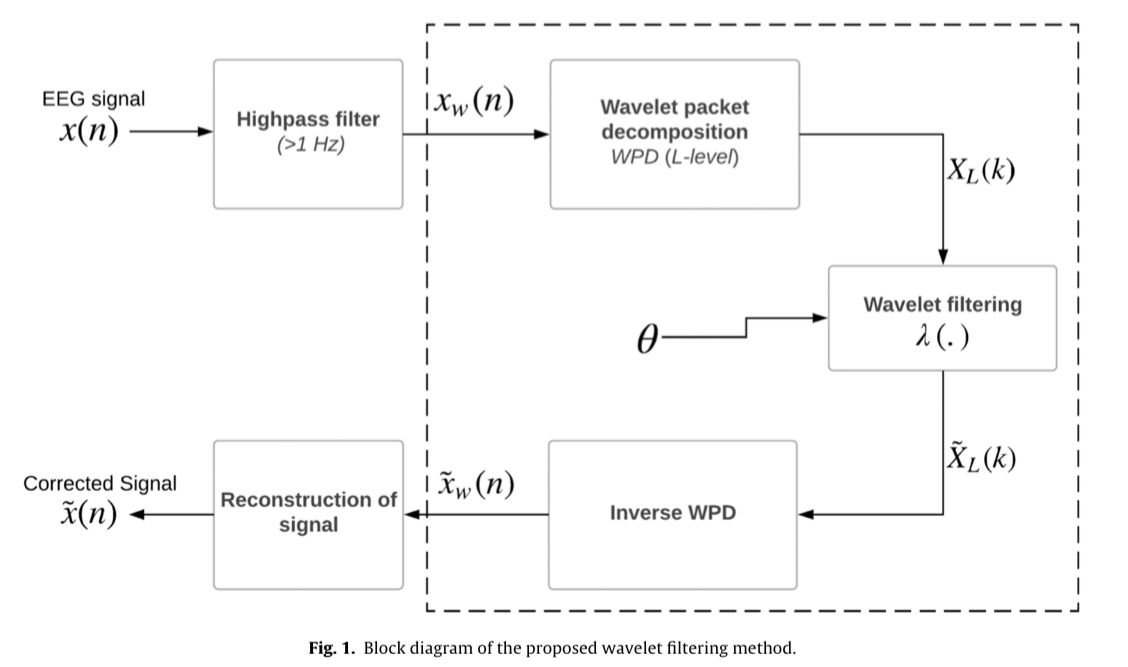

In [ ]:
def filtrar_HP_EOG(sig, fs):
  signal=[]
  N = 2**1
  wn = 0.5
  for j in range(len(sig)):
    sujeto=[]
    for i in range(19):
      filtro = butter(N, wn, btype = 'highpass', fs = fs, output='sos')
      canal= sosfiltfilt(filtro,sig[j][i], axis = 0)
      sujeto+=[canal]
    signal+=[sujeto]
  return signal

def filtrar_EOG(signal, fs):
  signal_EOG=[]
  for j in range(len(signal)):
    sujeto=spk.eeg.ATAR(np.array(signal[j]).T,OptMode='elim',verbose=0,k1=1200)
    signal_EOG+=[sujeto.T]
  return signal_EOG

ADHD_EOG_0=filtrar_HP_EOG(ADHD_RD,fs)
print('---------------')
CTRL_EOG_0=filtrar_HP_EOG(CTRL_RD,fs)
print('---------------')

ADHD_EOG=filtrar_EOG(ADHD_EOG_0, fs)
print('---------------')
CTRL_EOG=filtrar_EOG(CTRL_EOG_0, fs)

---------------
---------------
---------------


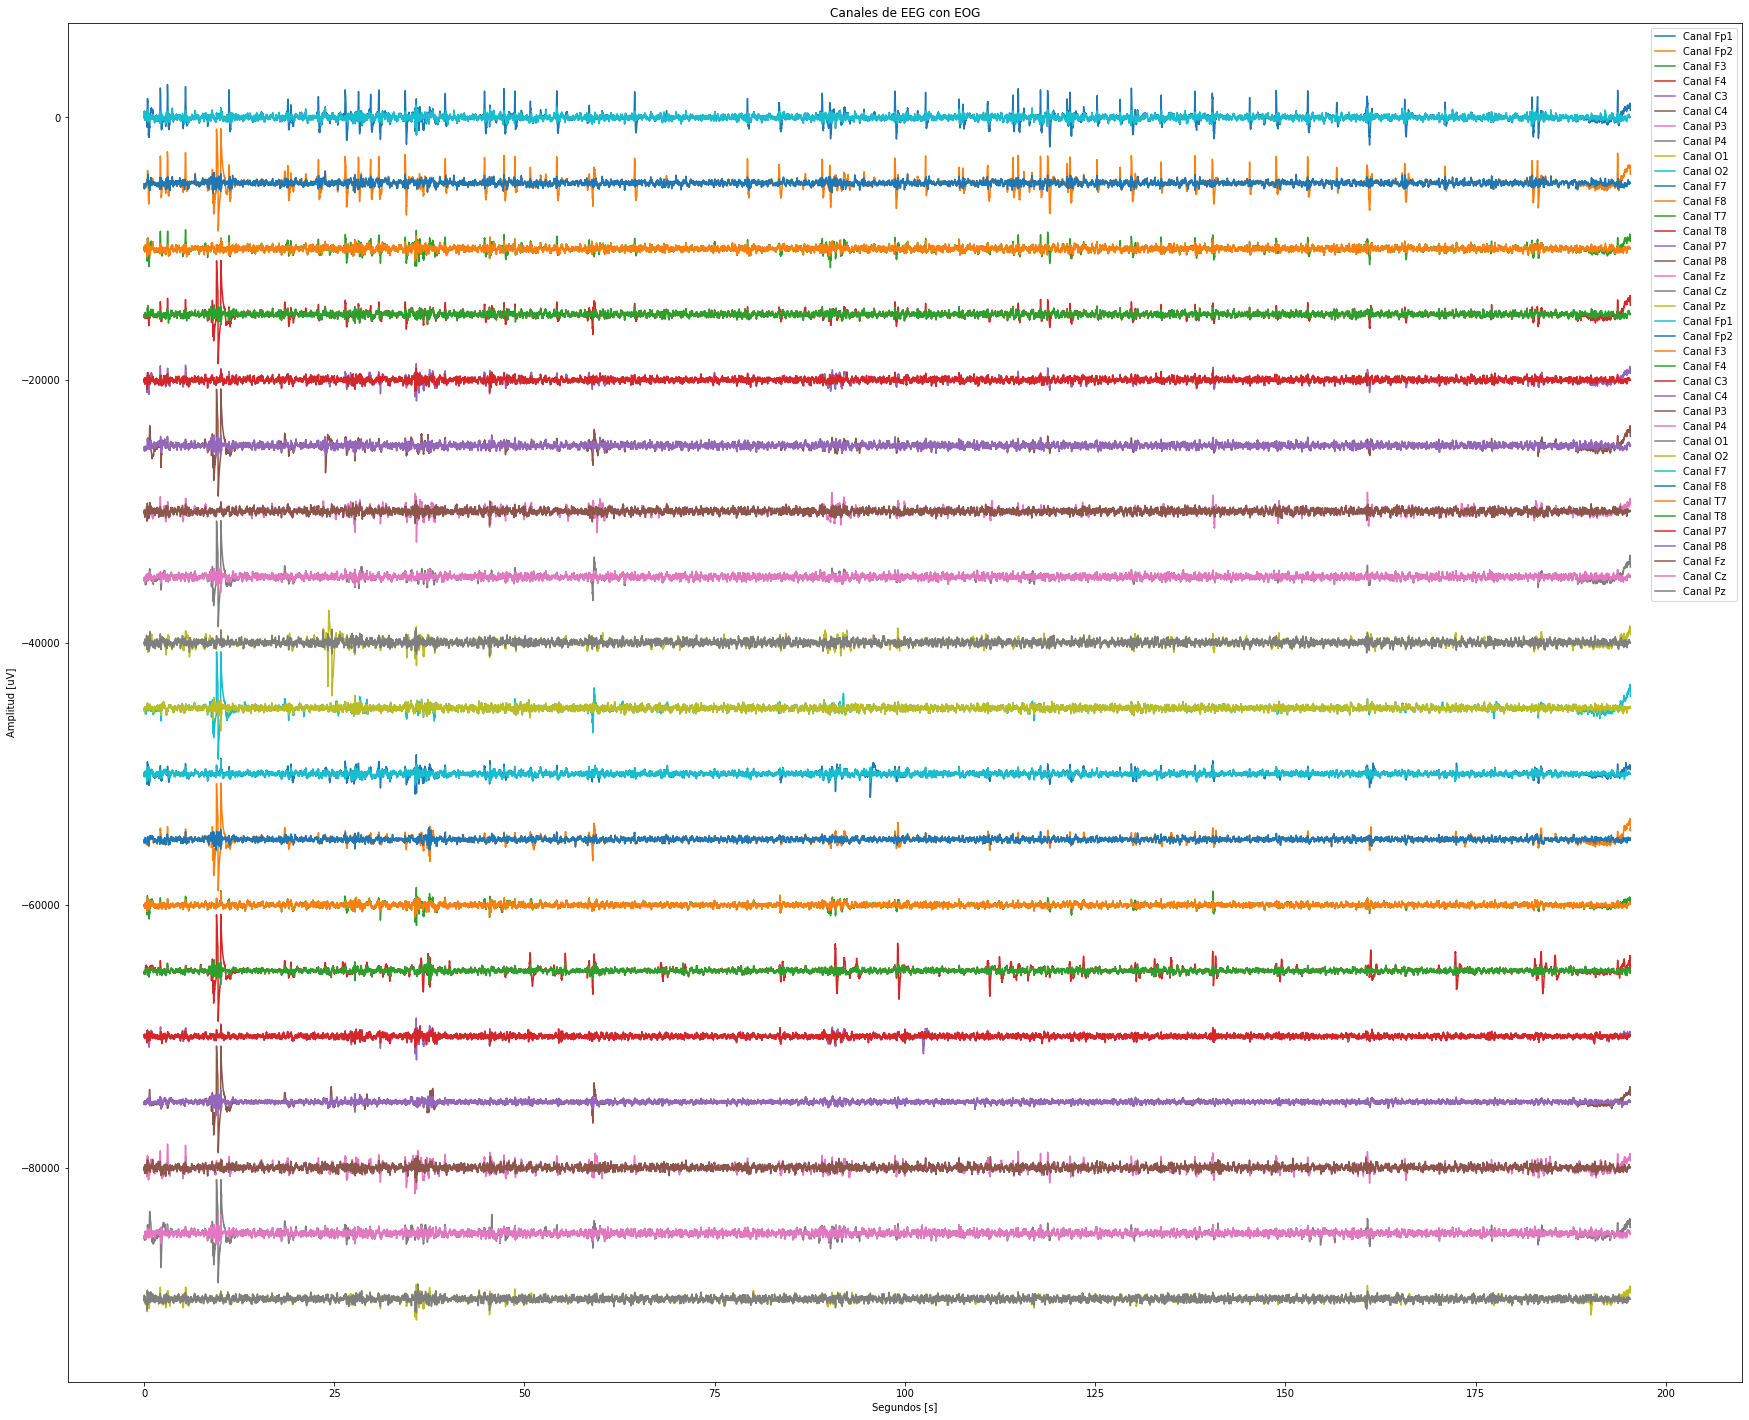

In [ ]:
plt.figure(figsize=(30,25))
titulo = 'Canales de EEG con EOG'

for j in range(len(ADHD_RD[6])):
  t1=np.arange(0,len(ADHD_RD[6][j])/fs,1/fs)
  plt.plot(t1,ADHD_RD[6][j]-j*5000, label = f'Canal {canales[j]}')

plt.xlabel('Segundos [s]')
plt.ylabel('Amplitud [uV]')
plt.xlim([-10,210])
plt.title(titulo)
plt.legend(loc = 'upper right')

for j in range(len(ADHD_EOG[6])):
  t1=np.arange(0,len(ADHD_EOG[6][j])/fs,1/fs)
  plt.plot(t1,ADHD_EOG[6][j]-j*5000, label = f'Canal {canales[j]}')

plt.xlabel('Segundos [s]')
plt.ylabel('Amplitud [uV]')
plt.xlim([-10,210])
plt.title(titulo)
plt.legend(loc = 'upper right')
plt.show()

A continuación se muestra el espectrograma de una persona con ADHD antes y después de filtrar el ruido de EOG.

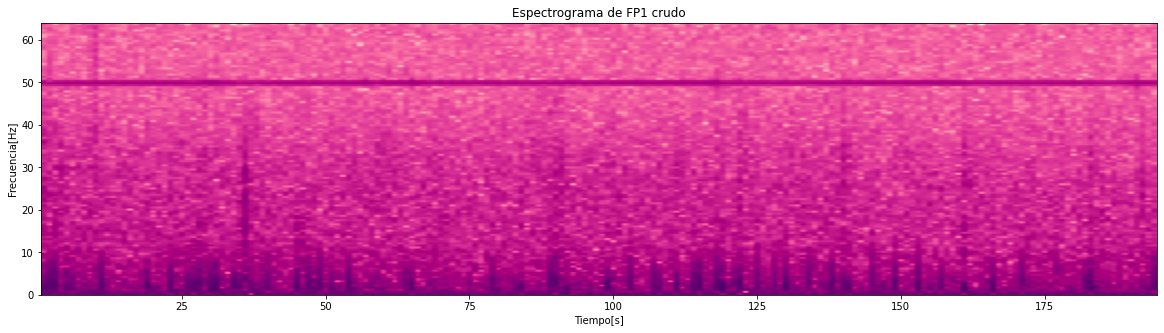

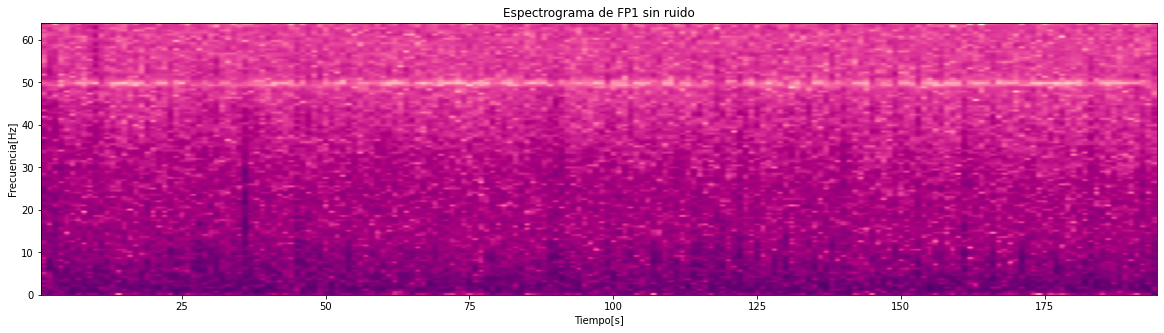

In [ ]:
#espectrograma

plt.figure(figsize = (20,5))
_ = plt.specgram(ADHD_data[6][:,0], Fs=fs, cmap='RdPu')
t=np.arange(0,len(ADHD_data[6][:,0])/fs,1/fs)
plt.ylim(0,64)
plt.xlabel('Tiempo[s]')
plt.ylabel('Frecuencia[Hz]')
plt.title('Espectrograma de FP1 crudo')
plt.show()

plt.figure(figsize = (20,5))
_ = plt.specgram(ADHD_EOG[6][0], Fs=fs, cmap='RdPu')
t=np.arange(0,len(ADHD_EOG[6][0])/fs,1/fs)
plt.ylim(0,64)
plt.xlabel('Tiempo[s]')
plt.ylabel('Frecuencia[Hz]')
plt.title('Espectrograma de FP1 sin ruido')
plt.show()

##Recorte

En diversos estudios se observó que los electrodos fronto-centrales son aquellos que contienen la información más relevante para pacientes con ADHD (Lenartowicz et al., 2014). En este caso se utilizarán en particular: Fp1, Fp2, F3, F4 y Fz.

In [ ]:
def canales_importantes(sig):
  new_sig=[]
  for i in range(len(sig)):
    canales = sig[i][:4]
    canales = np.append(canales, [sig[i][16]], axis=0)
    new_sig+=[canales]
  return new_sig

In [ ]:
ADHD_ci = canales_importantes(ADHD_EOG)
CTRL_ci = canales_importantes(CTRL_EOG)

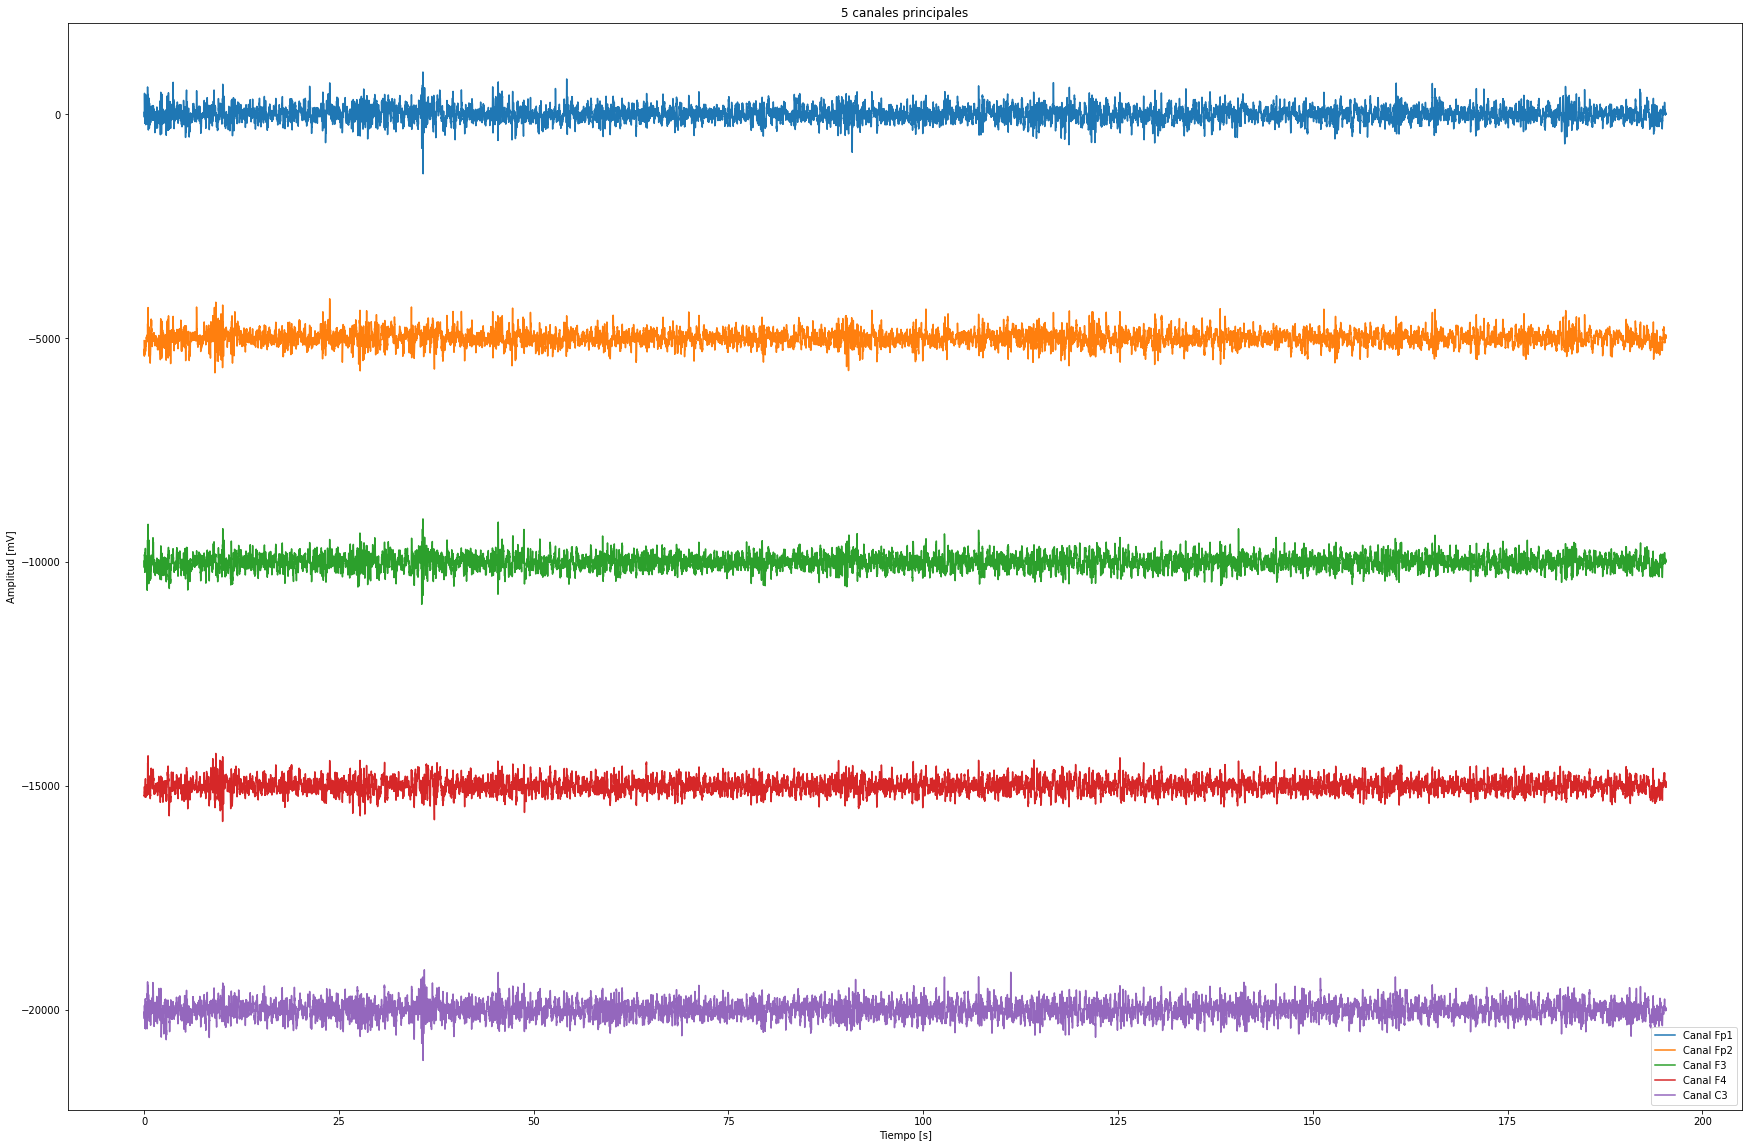

In [ ]:
grafico_prueba(ADHD_ci[6], 128, '5 canales principales')

A continución se buscan intervalos en los cuales la señal es estacionaria en los 5 canales. La estacionaridad se comprueba a través de la función `test_stationarity` de la biblioteca Tensorpac. Allí se define el p-value en 0,1. Este parámetro se usa para inferir si la señal es significativamente estacionaria.

 

In [ ]:
from tensorpac.stats import test_stationarity

def recorte(signal, ini):
  new=[]
  for j in range(len(signal)):
      canal=signal[j][ini:ini+1280]
      new+=[canal]
  new_array=np.array(new)
  return new_array

def elijo_recorte(signal):
  comienzo=1280
  new_signal=recorte(signal,comienzo)
  #ejemplo
  df = test_stationarity(new_signal, p=0.1)
  while(df['Stationary'].value_counts()[1]<5):
    if(comienzo+448 < np.shape(signal)[1]): # avanzo de a dos segundos hasta encontrar un segmento bastante estacionario
      comienzo+=192
      new_signal=recorte(signal,comienzo)
      df = test_stationarity(new_signal, p=0.1)
    else: # si llegue al final sin encontrar un segmento estacionario defino un nuevo inicio y repito el procedimiento
      comienzo=random.randint(1280,1472)
      new_signal=recorte(signal,comienzo)
      df = test_stationarity(new_signal, p=0.1)
  return new_signal

segmento = elijo_recorte(ADHD_ci[6])

Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
INFO:tensorpac:Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
    5/5 epochs were found as significantly stationary at p=0.1
INFO:tensorpac:    5/5 epochs were found as significantly stationary at p=0.1


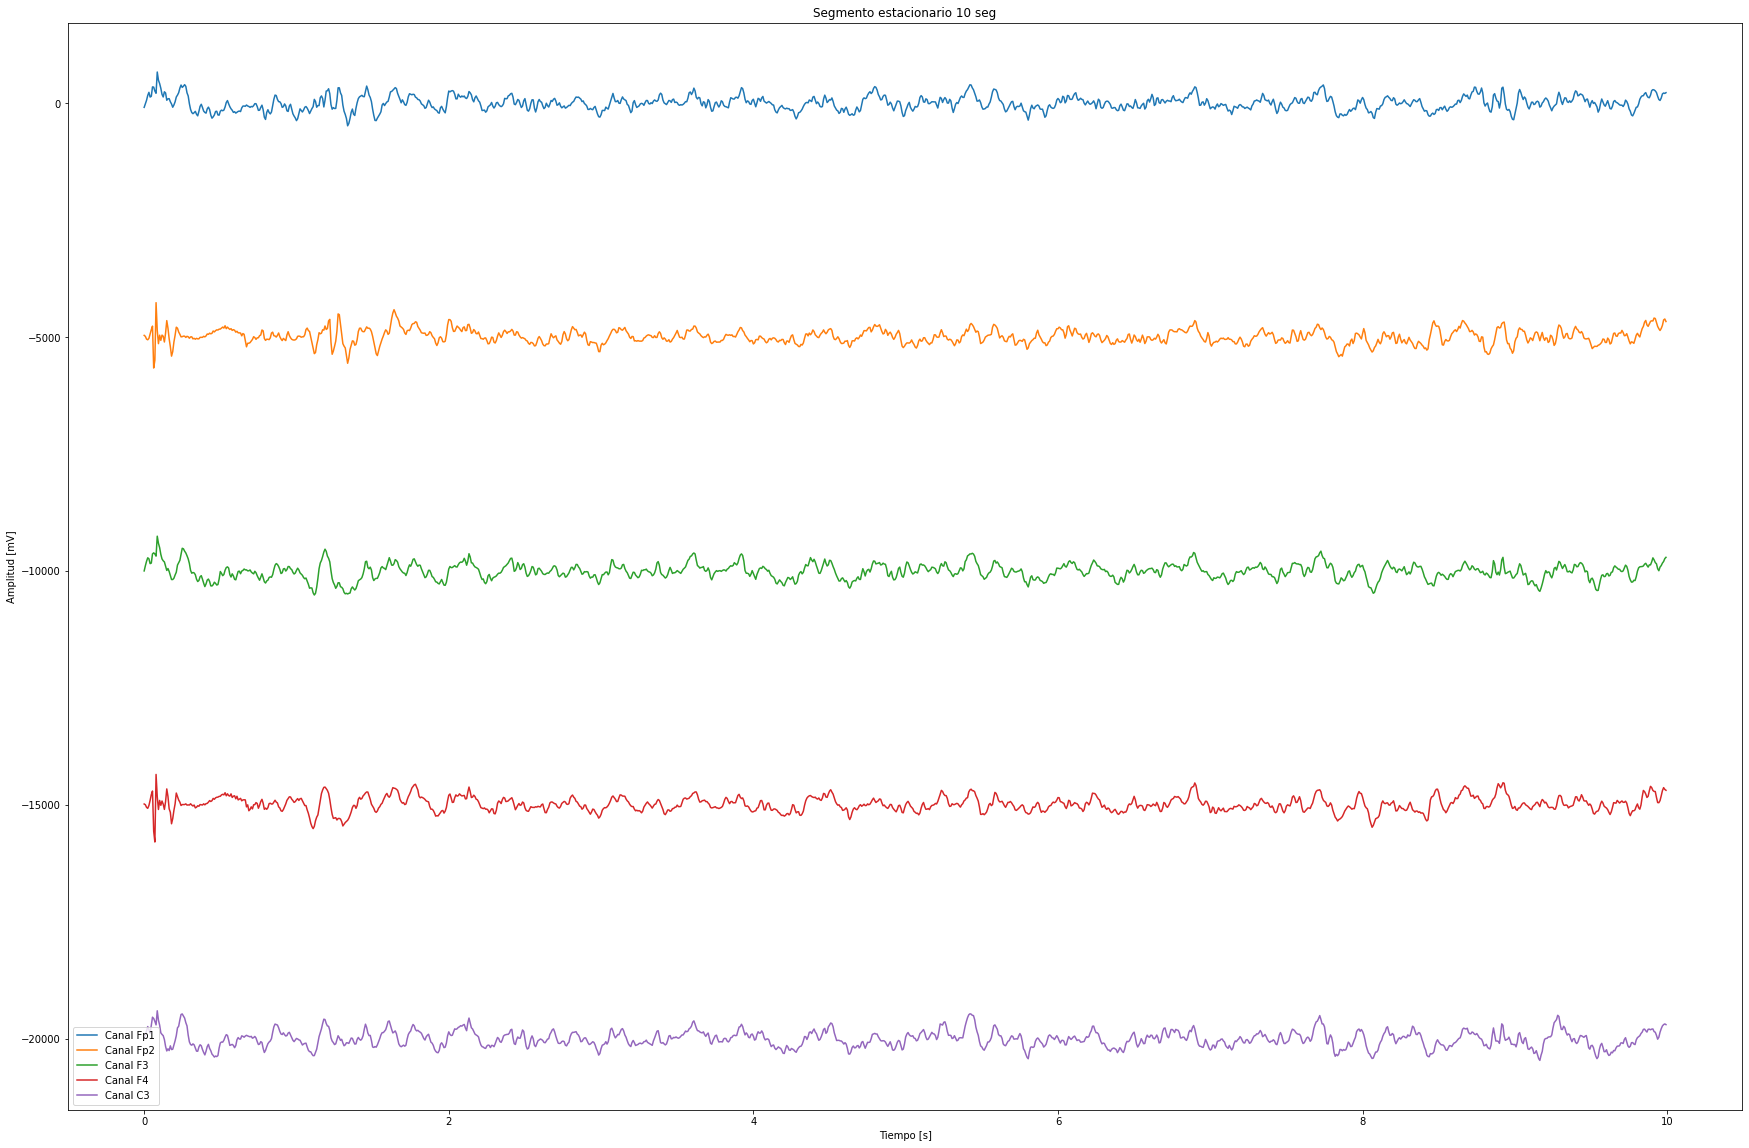

In [ ]:
grafico_prueba(segmento, 128, 'Segmento estacionario 10 seg')

In [ ]:
ADHD_cut=[] 
for i in range(len(ADHD_ci)):
  nueva=elijo_recorte(ADHD_ci[i])
  ADHD_cut+=[nueva]

print('\n--------------------\n')

CTRL_cut=[]
for i in range(len(CTRL_ci)):
  nueva=elijo_recorte(CTRL_ci[i])
  CTRL_cut+=[nueva]

print(np.shape(ADHD_cut[0]))
print(np.shape(CTRL_cut[0]))

Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
INFO:tensorpac:Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
    5/5 epochs were found as significantly stationary at p=0.1
INFO:tensorpac:    5/5 epochs were found as significantly stationary at p=0.1
Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
INFO:tensorpac:Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
    5/5 epochs were found as significantly stationary at p=0.1
INFO:tensorpac:    5/5 epochs were found as significantly stationary at p=0.1
Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
INFO:tensorpac:Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
    5/5 epochs were found as significantly stationary at p=0.1
INFO:tensorpac:    5/5 epochs were found as significantly stationary at p=0.1
Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
INFO:tensorpac:Performing a Augmented Dickey-Fuller test on 5 epochs with p=0


--------------------



    5/5 epochs were found as significantly stationary at p=0.1
INFO:tensorpac:    5/5 epochs were found as significantly stationary at p=0.1
Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
INFO:tensorpac:Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
    5/5 epochs were found as significantly stationary at p=0.1
INFO:tensorpac:    5/5 epochs were found as significantly stationary at p=0.1
Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
INFO:tensorpac:Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
    5/5 epochs were found as significantly stationary at p=0.1
INFO:tensorpac:    5/5 epochs were found as significantly stationary at p=0.1
Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
INFO:tensorpac:Performing a Augmented Dickey-Fuller test on 5 epochs with p=0.1
    5/5 epochs were found as significantly stationary at p=0.1
INFO:tensorpac:    5/5 epochs were found as significantly stationary at p=0.1
P

(5, 1280)
(5, 1280)


# Reconocimiento de ADHD

<p alaign='justify'>A continuación se diseñó un algoritmo que detecte la presencia de ADHD en base a distintos parámetros:</p>



*   Duración de la señal. Ya que esta corresponde al tiempo que le llevó al sujeto realizar la tarea, podría inferirse que alguien con ADHD tarde más en realizar una acción que requiera de su atención.
*   Actividad theta aumentada (es decir, 4 a 8 Hz), que promueve el sueño y disminuye la concentración.
* Actividad delta aumentada (0,5 a 4 Hz) - característica del sueño profundo y la meditación.
* Potencia de los ritmos beta disminuida (13 a 30 Hz). Estos son característicos de la vigilia atenta.
* Potencia de los ritmos gamma disminuida (30 a 45 Hz). Estos se correlacionan con el procesamiento consciente de información.
* Ratio theta/beta. Este parámetro evidencia el comportamiento inverso que tienen estos dos ritmos cerebrales en pacientes con ADHD
* Dimensión fractal. Se trata de un número real que se define según cuán completamente parece llenar un fractal el espacio conforme se amplía el primero hacia escalas más y más finas. No existe una única dimensión fractal sino una serie de dimensiones que, frecuentemente, resultan equivalentes aunque no siempre. Es una medida de la complejidad de un objeto, y disminuye en muestras de EEG de personas con ADHD.
* Entropía. Mide el grado de organización del sistema y, por lo tanto, cuan predecible es una muestra. Disminuye en personas con ADHD.
* Otros parámetros no lineales como el exponente de Lyapunov, la dimensión de correlación y el exponente de Hurst, que también son indicadores del grado de organización del sistema.




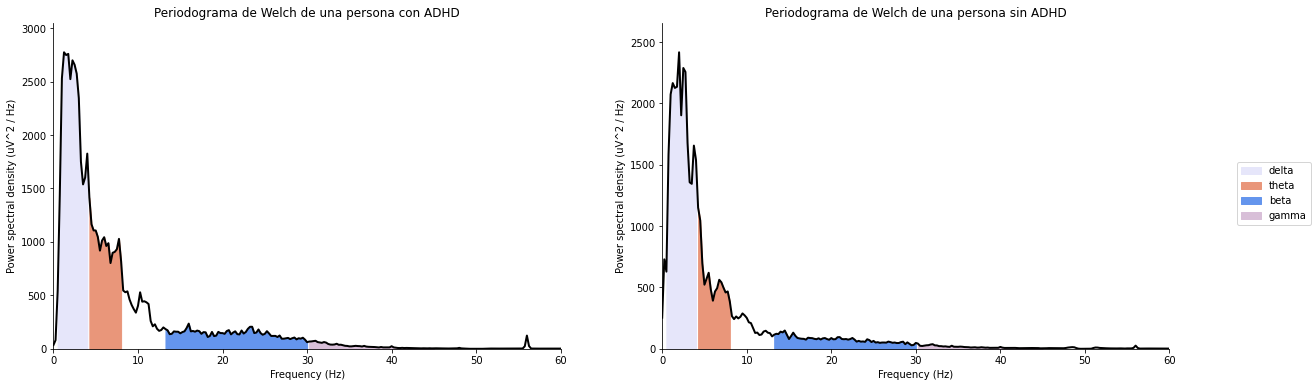

In [ ]:
win = 4*fs
f1, psd1 = welch(np.ravel(ADHD_ci[45][4]), fs, nperseg=win, window='hamming')
f2, psd2 = welch(np.ravel(CTRL_ci[15][4]), fs, nperseg=win, window='hamming')

idx1_delta = np.logical_and(f1 >= 0.5, f1 <= 4.0)
idx1_theta = np.logical_and(f1 >= 4.1, f1 <= 8.0)
idx1_beta = np.logical_and(f1 >= 13.1, f1 <= 30.0)
idx1_gamma = np.logical_and(f1 >= 30.1, f1 <= 45.0)
idx2_delta = np.logical_and(f2 >= 0.5, f2 <= 4.0)
idx2_theta = np.logical_and(f2 >= 4.1, f2 <= 8.0)
idx2_beta = np.logical_and(f2 >= 13.1, f2 <= 30.0)
idx2_gamma = np.logical_and(f2 >= 30.1, f2 <= 45.0)

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(20, 6))
axes[0].plot(f1, psd1, lw=2, color='k')
axes[0].fill_between(f1, psd1, where=idx1_delta, color='lavender')
axes[0].fill_between(f1, psd1, where=idx1_theta, color='darksalmon')
axes[0].fill_between(f1, psd1, where=idx1_beta, color='cornflowerblue')
axes[0].fill_between(f1, psd1, where=idx1_gamma, color='thistle')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power spectral density (uV^2 / Hz)')
axes[0].set_xlim([0, 60])
axes[0].set_ylim([0, psd1.max() * 1.1])
axes[0].set_title("Periodograma de Welch de una persona con ADHD")

axes[1].plot(f2, psd2, lw=2, color='k')
axes[1].fill_between(f2, psd2, where=idx2_delta, color='lavender',label='delta')
axes[1].fill_between(f2, psd2, where=idx2_theta, color='darksalmon',label='theta')
axes[1].fill_between(f2, psd2, where=idx2_beta, color='cornflowerblue',label='beta')
axes[1].fill_between(f2, psd2, where=idx2_gamma, color='thistle',label='gamma')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power spectral density (uV^2 / Hz)')
axes[1].set_xlim([0, 60])
axes[1].set_ylim([0, psd2.max() * 1.1])
axes[1].set_title("Periodograma de Welch de una persona sin ADHD")
fig.legend(loc='center right')
sns.despine()
plt.show()
print('\n')

## Duración
La duración en segundos se calcula simplemente contando el número de muestras en la señal y dividiendo por la frecuencia de muestreo.

In [ ]:
def duracion(signal, fs):
  t = round(np.shape(signal)[1]/fs,2)
  return t

## Ritmos cerebrales
Luego, se realiza un promedio de la densidad espectral de potencia para los distintos ritmos cerebrales (beta, theta, gamma y delta) estimando el mismo a través del método de Welch.

En particular, para pacientes con ADHD se espera un decrecimiento en el caso de gamma y beta, y un aumento para theta y delta (Ortiz et al., 2015).

In [ ]:
def theta(sig, Fs):
  psd_prom = 0
  win = 4*Fs
  low, high = 4.1, 8.0
  for i in range(len(sig)):
    f, psd = welch(np.ravel(sig[i]), Fs, nperseg=win, window='hamming')
    dif=f[1]-f[0]
    for j in range(len(f)):
      if f[j]>= low and f[j]<=high:
        psd_prom += (psd[j]*dif)/(high-low)
  psd_prom = round(psd_prom,2)
  return psd_prom

In [ ]:
def beta(sig, Fs):
  psd_prom = 0
  win = 4*Fs
  low, high = 13.1, 30.0
  for i in range(len(sig)):
    f, psd = welch(np.ravel(sig[i]), Fs, nperseg=win, window='hamming')
    dif=f[1]-f[0]
    for j in range(len(f)):
      if f[j]>= low and f[j]<=high:
        psd_prom += (psd[j]*dif)/(high-low)
  psd_prom = round(psd_prom,2)
  return psd_prom

In [ ]:
def gamma(sig, Fs):
  psd_prom = 0
  win = 4*Fs
  low, high = 30.1, 45.0
  for i in range(len(sig)):
    f, psd = welch(np.ravel(sig[i]), Fs, nperseg=win, window='hamming')
    dif=f[1]-f[0]
    for j in range(len(f)):
      if f[j]>= low and f[j]<=high:
        psd_prom += (psd[j]*dif)/(high-low)
  psd_prom = round(psd_prom,2)
  return psd_prom

In [ ]:
def delta(sig, Fs):
  psd_prom = 0
  win = 4*Fs
  low, high = 0.5, 4.0
  for i in range(len(sig)):
    f, psd = welch(np.ravel(sig[i]), Fs, nperseg=win, window='hamming')
    dif=f[1]-f[0]
    for j in range(len(f)):
      if f[j]>= low and f[j]<=high:
        psd_prom += (psd[j]*dif)/(high-low)
  psd_prom = round(psd_prom,2)
  return psd_prom

## Dimensión fractal
Los fractales son objetos geométricos cuya estructura básica se repite a distintas escalas. La dimensión fractal se utiliza para cuantificar la complejidad de estos objetos, donde sus valores más grandes indican una mayor complejidad. En los últimos años se ha utilizado este parámetro no lineal para analizar la complejidad de series de tiempo fisiológicas.

En particular, en la función `fractal_dimension` se implementa, a través de una función de la biblioteca Antropy, el método de Higuchi para la aproximación a la dimensión fractal de una función real o una serie de tiempo.

Dada una serie de tiempo X con N puntos de datos tal que X: {0, ..., N} → ℜ y siendo el parámetro k_max ≽ 2. Para todo k ∈ {1, ..., k_max} y m ∈ {1, ..., k}, se define la longitud L_m(x) según: 



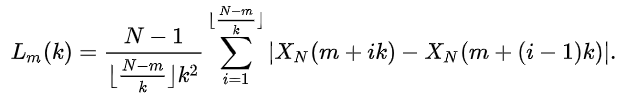

Luego, se define la longitud L(k) según el promedio de las k longitudes L_1(x), ..., L_k(x).

Finalmente, la dimensión fractal corresponderá a la pendiente de la función lineal que mejor se ajuste a los puntos de datos {(log(1/k), log(L(k))}. 

In [ ]:
def fractal_dimension(sig):
  fd_prom=0
  for i in range(len(sig)):
    fd=ant.higuchi_fd(sig[i])
    fd_prom+=fd
  fd_prom = round(fd_prom/len(sig),2)
  return fd_prom

## Entropía

La entropía ayuda a medir la predictibilidad de una muestra. Para pacientes con ADHD, se espera una disminución en dicho parámetro. A continuación se emplea el algoritmo denominado *sample entropy* a través de una función de la biblioteca Antropy. Dicho método es menos sensible a los cambios en la longitud de los datos y tiene menos complicaciones con la consistencia relativa (Yentes et al., 2013).

In [ ]:
def samp_entropy(sig):
  total=0
  for i in range(len(sig)):
    aux=ant.sample_entropy(sig[i])
    total+=aux
  prom=total/len(sig)
  return prom

## Otros parámetros no lineales
Además se calculan otros parámetros no lineales indicadores del grado de organización de la serie temporal que guardan una enorme correlación con la presencia de ADHD (Boroujeni et al., 2019). Estos parámetros son:

* Exponente de Lyapunov
* Dimensión de correlación
* Exponente de Hurst


In [ ]:
def ly_exponent(sig):
  total=0
  for i in range(len(sig)):
    aux= nolds.lyap_r(sig[i],tau=1,emb_dim=10)
    total+=aux
  prom=total/len(sig)
  return prom

In [ ]:
def corr_dimension(sig):
  total=0
  for i in range(len(sig)):
    aux= nolds.corr_dim(sig[i],2)
    total+=aux
  prom=total/len(sig)
  return prom

In [ ]:
def h_exp(sig):
  total=0
  for i in range(len(sig)):
    aux= nolds.hurst_rs(sig[i],)
    total+=aux
  prom=total/len(sig)
  return prom

In [ ]:
def parametros(signal1, signal2, Fs):
  valores = []
  for i in range(len(signal1)):
    par = []
    par.append(duracion(signal1[i], Fs))
    t=theta(signal1[i],Fs)
    b=beta(signal1[i],Fs)
    par.append(t)
    par.append(b)
    par.append(fractal_dimension(signal2[i])) 
    par.append(samp_entropy(signal2[i]))
    par.append(ly_exponent(signal2[i]))
    par.append(corr_dimension(signal2[i]))
    par.append(h_exp(signal2[i]))
    par.append(gamma(signal1[i],Fs))
    par.append(t/b)
    par.append(delta(signal1[i], Fs))
    if(len(signal1)==60):
      par.append(0)
    else:
      par.append(1)
    valores.append(par)
    print(i)
  return valores

Luego se calculan los parámetros para cada grupo.

In [ ]:
x = parametros(ADHD_ci, ADHD_cut, fs)
print('-----------')
y = parametros(CTRL_ci, CTRL_cut, fs)
x+=y
print(np.shape(x))

/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


0


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


1


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


2


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


3


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


4


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


5


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


6


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


7


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


8


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


9


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


10


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


11


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


12


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


13


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


14


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


15


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


16


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


17


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


18


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


19


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


20


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


21


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


22


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


23


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


24


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


25


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


26


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


27


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


28


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


29


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


30


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


31


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


32


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


33


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


34


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


35


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


36


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


37


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


38


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


39


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


40


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


41


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


42


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


43


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


44


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


45


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


46


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


47


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


48


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


49


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


50


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


51


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


52


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


53


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


54


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


55


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


56


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


57


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


58


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


59


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


60
-----------


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


0


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


1


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


2


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


3


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


4


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


5


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


6


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


7


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


8


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


9


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


10


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


11


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


12


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


13


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


14


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


15


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


16


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


17


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


18


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


19


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


20


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


21


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


22


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


23


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


24


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


25


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


26


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


27


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


28


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


29


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


30


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


31


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


32


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


33


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


34


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


35


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


36


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


37


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


38


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


39


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


40


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


41


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


42


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


43


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


44


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


45


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


46


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


47


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


48


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


49


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


50


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


51


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


52


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


53


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


54


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


55


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


56


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


57


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


58


/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 320
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


59
(121, 12)


# Aprendizaje Automático

A continuación se generó un algoritmo de aprendizaje automático para la detección de ADHD según las características descriptas en la sección anterior.

## Organización de los datos
Mediante el uso de la biblioteca `pandas` se genera un dataframe.

In [ ]:
df = pd.DataFrame(x, columns = ['duracion [s]', 'theta [uV^2 / Hz]', 'beta [uV^2 / Hz]', 'fractal dimension','entropia','Lyapunov exp','correlation dimension', 'Hurst exp','gamma [uV^2 / Hz]','theta/beta ratio','delta [uV^2 / Hz]','ADHD'])

In [ ]:
df.head(10)

duracion [s]  theta [uV^2 / Hz]  beta [uV^2 / Hz]  fractal dimension  \
0        192.93            5251.34            546.82               1.53   
1        215.72            5343.87           1146.49               1.62   
2         77.30            4628.81            439.73               1.50   
3        111.75            4000.09            381.72               1.52   
4        135.95            5142.75            679.04               1.56   
5        137.20            8550.43           1216.15               1.60   
6        195.34            7784.56            709.80               1.49   
7        142.01            4767.01            418.37               1.49   
8        189.38            4320.20           1192.41               1.72   
9        137.53            5472.66            284.71               1.42   

   entropia  Lyapunov exp  correlation dimension  Hurst exp  \
0  1.160030      0.019382               1.834100   0.801594   
1  1.303146      0.030298               1.849282   0.786421   
2  1.076852      0.028631               1.818098   0.744900   
3  1.164103      0.027146               1.846188   0.731617   
4  1.276028      0.030171               1.849233   0.795954   
5  1.231789      0.033860               1.855631   0.740761   
6  1.114783      0.025828               1.836109   0.777973   
7  1.082341      0.016567               1.824824   0.813357   
8  1.527328      0.040115               1.864627   0.729040   
9  1.064951      0.023474               1.823475   0.734396   

   gamma [uV^2 / Hz]  theta/beta ratio  delta [uV^2 / Hz]  ADHD  
0              91.75          9.603416           13835.60     1  
1             232.09          4.661070           13086.93     1  
2              53.44         10.526482           12947.82     1  
3              50.79         10.479121           10592.18     1  
4             132.07          7.573560           17228.43     1  
5             101.16          7.030736           17473.95     1  
6             109.62         10.967258           18840.16     1  
7              42.11         11.394244           13356.79     1  
8             139.98          3.623083           10615.34     1  
9              38.16         19.221875           14041.22     1

In [ ]:
df.tail(10)

duracion [s]  theta [uV^2 / Hz]  beta [uV^2 / Hz]  fractal dimension  \
111        117.76            3104.77            414.94               1.59   
112        174.01            6940.55            634.93               1.53   
113        138.92            4007.49            314.78               1.51   
114        139.38            4295.61            767.03               1.58   
115        120.14            1890.72            355.08               1.61   
116        130.36            4230.65            730.53               1.58   
117        173.91            7408.29           1319.72               1.62   
118        203.01            8498.49            670.12               1.44   
119        193.89            5176.73            681.20               1.56   
120        115.01            3316.02           1088.26               1.64   

     entropia  Lyapunov exp  correlation dimension  Hurst exp  \
111  1.332782      0.035140               1.764666   0.784561   
112  1.149934      0.028086               1.838501   0.753710   
113  1.194096      0.026756               1.837873   0.780993   
114  1.171678      0.026665               1.836146   0.795161   
115  1.293799      0.025423               1.786668   0.813489   
116  1.319859      0.028955               1.825816   0.804386   
117  1.297366      0.035507               1.854263   0.752282   
118  1.028903      0.023630               1.812187   0.782342   
119  1.211341      0.026150               1.840983   0.791791   
120  1.270730      0.028490               1.842421   0.811049   

     gamma [uV^2 / Hz]  theta/beta ratio  delta [uV^2 / Hz]  ADHD  
111              73.64          7.482455            6702.01     0  
112              86.16         10.931205           15114.93     0  
113              48.84         12.731082            9078.82     0  
114              74.00          5.600316            9942.15     0  
115              88.64          5.324772            6255.15     0  
116             174.34          5.791206           12662.57     0  
117             140.48          5.613532           15041.15     0  
118              88.66         12.682042           17646.24     0  
119              96.41          7.599427           15617.16     0  
120             132.66          3.047084           12421.73     0

## Evaluación de los parámetros

Para conseguir un algoritmo que clasifique correctamente los datos, se deben encontrar parámetros que distingan el caso 0 (sin ADHD) del caso 1 (con ADHD). Para ello se muestran a continuación gráficos de distribución de población y boxplots para cada uno de los parámetros definidos.

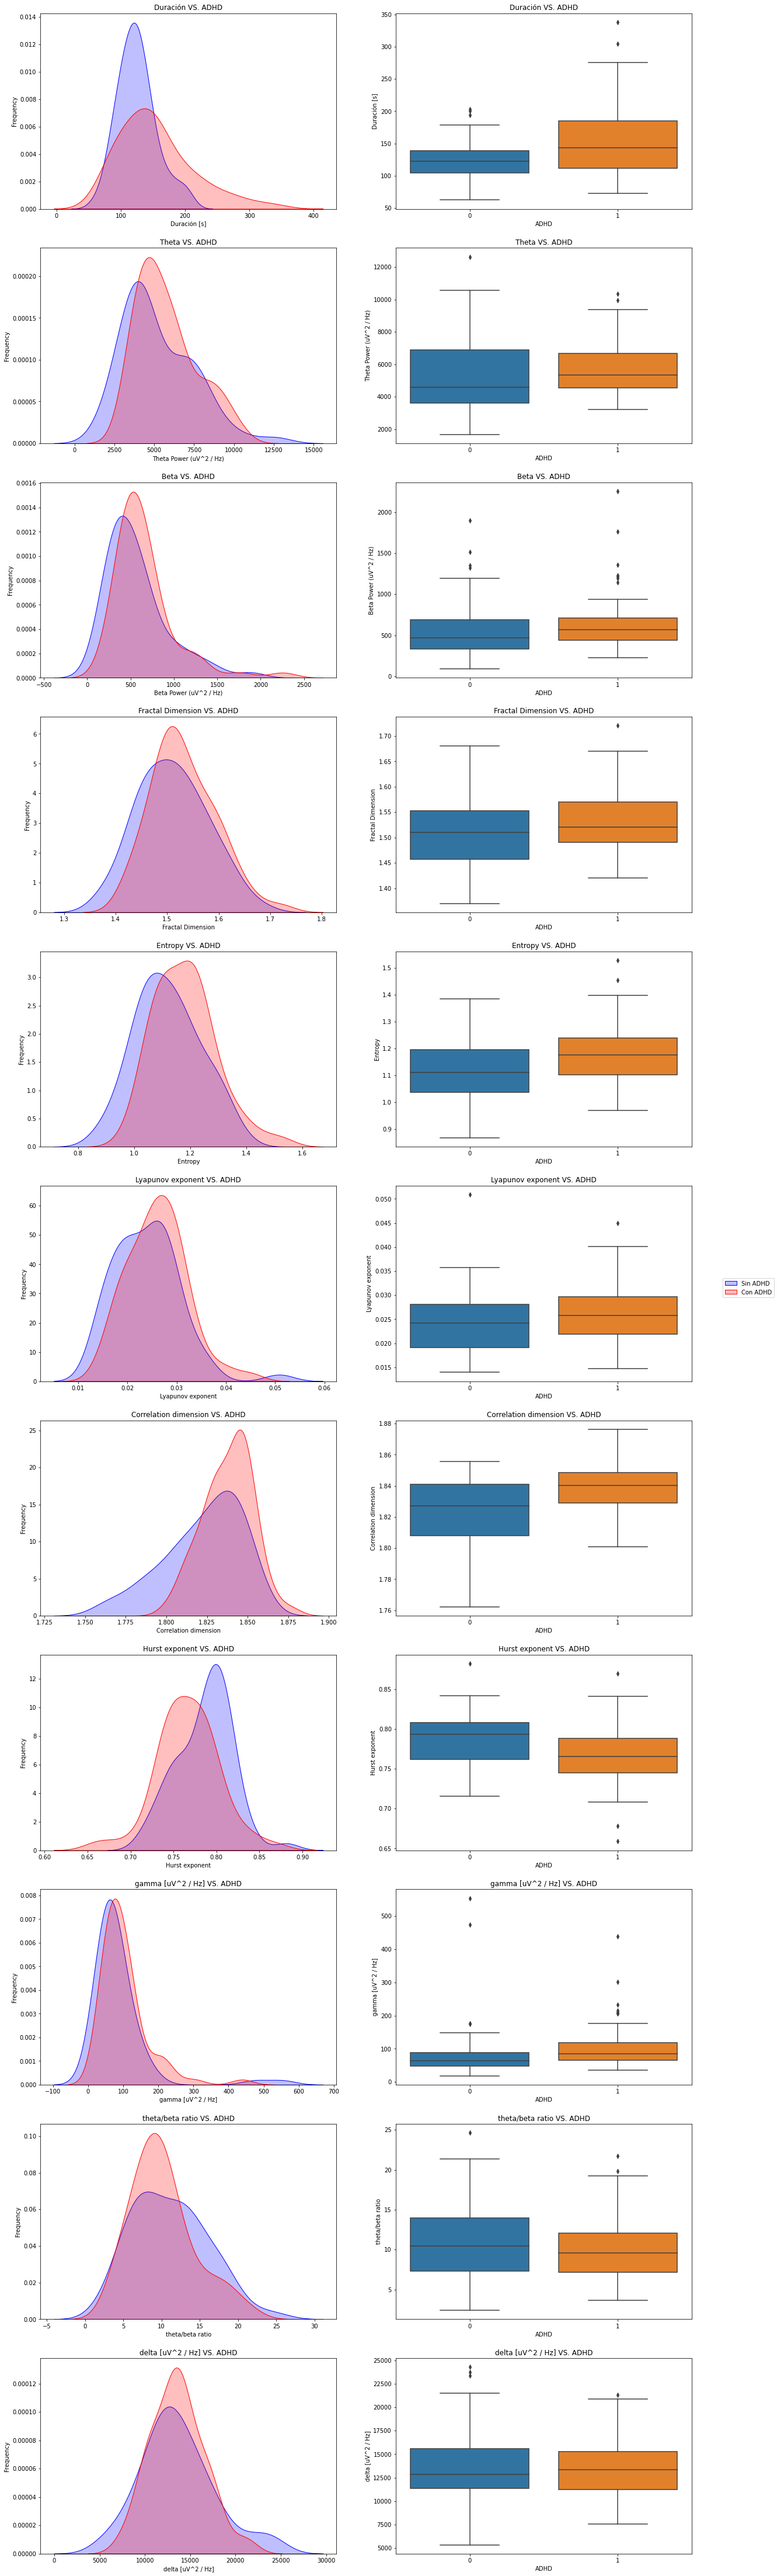

In [ ]:
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(20,80))

sns.kdeplot(df.loc[(df['ADHD'] == 0),'duracion [s]'] , color='b',shade=True, label='Sin ADHD' , ax = axes[0][0])
sns.kdeplot(df.loc[(df['ADHD'] == 1),'duracion [s]'] , color='r',shade=True, label='Con ADHD', ax = axes[0][0])
axes[0][0].set_xlabel('Duración [s]')
axes[0][0].set_ylabel('Frequency')
axes[0][0].set_title('Duración VS. ADHD')

sns.boxplot(data = df, x = 'ADHD', y = 'duracion [s]' , ax = axes[0][1])
axes[0][1].set_xlabel('ADHD')
axes[0][1].set_ylabel('Duración [s]')
axes[0][1].set_title('Duración VS. ADHD')

sns.kdeplot(df.loc[(df['ADHD'] == 0),'theta [uV^2 / Hz]'] , color='b',shade=True, ax = axes[1][0])
sns.kdeplot(df.loc[(df['ADHD'] == 1),'theta [uV^2 / Hz]'] , color='r',shade=True, ax = axes[1][0])
axes[1][0].set_xlabel('Theta Power (uV^2 / Hz)')
axes[1][0].set_ylabel('Frequency')
axes[1][0].set_title('Theta VS. ADHD')

sns.boxplot(data = df, x = 'ADHD', y = 'theta [uV^2 / Hz]' , ax = axes[1][1])
axes[1][1].set_xlabel('ADHD')
axes[1][1].set_ylabel('Theta Power (uV^2 / Hz)')
axes[1][1].set_title('Theta VS. ADHD')


sns.kdeplot(df.loc[(df['ADHD'] == 0),'beta [uV^2 / Hz]'] , color='b',shade=True, ax = axes[2][0])
sns.kdeplot(df.loc[(df['ADHD'] == 1),'beta [uV^2 / Hz]'] , color='r',shade=True, ax = axes[2][0])
axes[2][0].set_xlabel('Beta Power (uV^2 / Hz)')
axes[2][0].set_ylabel('Frequency')
axes[2][0].set_title('Beta VS. ADHD')

sns.boxplot(data = df, x = 'ADHD', y = 'beta [uV^2 / Hz]' , ax = axes[2][1])
axes[2][1].set_xlabel('ADHD')
axes[2][1].set_ylabel('Beta Power (uV^2 / Hz)')
axes[2][1].set_title('Beta VS. ADHD')

sns.kdeplot(df.loc[(df['ADHD'] == 0),'fractal dimension'] , color='b',shade=True, ax = axes[3][0])
sns.kdeplot(df.loc[(df['ADHD'] == 1),'fractal dimension'] , color='r',shade=True, ax = axes[3][0])
axes[3][0].set_xlabel('Fractal Dimension')
axes[3][0].set_ylabel('Frequency')
axes[3][0].set_title('Fractal Dimension VS. ADHD')

sns.boxplot(data = df, x = 'ADHD', y = 'fractal dimension' , ax = axes[3][1])
axes[3][1].set_xlabel('ADHD')
axes[3][1].set_ylabel('Fractal Dimension')
axes[3][1].set_title('Fractal Dimension VS. ADHD')

sns.kdeplot(df.loc[(df['ADHD'] == 0),'entropia'] , color='b',shade=True, ax = axes[4][0])
sns.kdeplot(df.loc[(df['ADHD'] == 1),'entropia'] , color='r',shade=True, ax = axes[4][0])
axes[4][0].set_xlabel('Entropy')
axes[4][0].set_ylabel('Frequency')
axes[4][0].set_title('Entropy VS. ADHD')

sns.boxplot(data = df, x = 'ADHD', y = 'entropia' , ax = axes[4][1])
axes[4][1].set_xlabel('ADHD')
axes[4][1].set_ylabel('Entropy')
axes[4][1].set_title('Entropy VS. ADHD')

sns.kdeplot(df.loc[(df['ADHD'] == 0),'Lyapunov exp'] , color='b',shade=True, ax = axes[5][0])
sns.kdeplot(df.loc[(df['ADHD'] == 1),'Lyapunov exp'] , color='r',shade=True, ax = axes[5][0])
axes[5][0].set_xlabel('Lyapunov exponent')
axes[5][0].set_ylabel('Frequency')
axes[5][0].set_title('Lyapunov exponent VS. ADHD')

sns.boxplot(data = df, x = 'ADHD', y = 'Lyapunov exp' , ax = axes[5][1])
axes[5][1].set_xlabel('ADHD')
axes[5][1].set_ylabel('Lyapunov exponent')
axes[5][1].set_title('Lyapunov exponent VS. ADHD')

sns.kdeplot(df.loc[(df['ADHD'] == 0),'correlation dimension'] , color='b',shade=True, ax = axes[6][0])
sns.kdeplot(df.loc[(df['ADHD'] == 1),'correlation dimension'] , color='r',shade=True, ax = axes[6][0])
axes[6][0].set_xlabel('Correlation dimension')
axes[6][0].set_ylabel('Frequency')
axes[6][0].set_title('Correlation dimension VS. ADHD')

sns.boxplot(data = df, x = 'ADHD', y = 'correlation dimension' , ax = axes[6][1])
axes[6][1].set_xlabel('ADHD')
axes[6][1].set_ylabel('Correlation dimension')
axes[6][1].set_title('Correlation dimension VS. ADHD')

sns.kdeplot(df.loc[(df['ADHD'] == 0),'Hurst exp'] , color='b',shade=True, ax = axes[7][0])
sns.kdeplot(df.loc[(df['ADHD'] == 1),'Hurst exp'] , color='r',shade=True, ax = axes[7][0])
axes[7][0].set_xlabel('Hurst exponent')
axes[7][0].set_ylabel('Frequency')
axes[7][0].set_title('Hurst exponent VS. ADHD')

sns.boxplot(data = df, x = 'ADHD', y = 'Hurst exp' , ax = axes[7][1])
axes[7][1].set_xlabel('ADHD')
axes[7][1].set_ylabel('Hurst exponent')
axes[7][1].set_title('Hurst exponent VS. ADHD')

sns.kdeplot(df.loc[(df['ADHD'] == 0),'gamma [uV^2 / Hz]'] , color='b',shade=True, ax = axes[8][0])
sns.kdeplot(df.loc[(df['ADHD'] == 1),'gamma [uV^2 / Hz]'] , color='r',shade=True, ax = axes[8][0])
axes[8][0].set_xlabel('gamma [uV^2 / Hz]')
axes[8][0].set_ylabel('Frequency')
axes[8][0].set_title('gamma [uV^2 / Hz] VS. ADHD')

sns.boxplot(data = df, x = 'ADHD', y = 'gamma [uV^2 / Hz]' , ax = axes[8][1])
axes[8][1].set_xlabel('ADHD')
axes[8][1].set_ylabel('gamma [uV^2 / Hz]')
axes[8][1].set_title('gamma [uV^2 / Hz] VS. ADHD')

sns.kdeplot(df.loc[(df['ADHD'] == 0),'theta/beta ratio'] , color='b',shade=True, ax = axes[9][0])
sns.kdeplot(df.loc[(df['ADHD'] == 1),'theta/beta ratio'] , color='r',shade=True, ax = axes[9][0])
axes[9][0].set_xlabel('theta/beta ratio')
axes[9][0].set_ylabel('Frequency')
axes[9][0].set_title('theta/beta ratio VS. ADHD')

sns.boxplot(data = df, x = 'ADHD', y = 'theta/beta ratio' , ax = axes[9][1])
axes[9][1].set_xlabel('ADHD')
axes[9][1].set_ylabel('theta/beta ratio')
axes[9][1].set_title('theta/beta ratio VS. ADHD')

sns.kdeplot(df.loc[(df['ADHD'] == 0),'delta [uV^2 / Hz]'] , color='b',shade=True, ax = axes[10][0])
sns.kdeplot(df.loc[(df['ADHD'] == 1),'delta [uV^2 / Hz]'] , color='r',shade=True, ax = axes[10][0])
axes[10][0].set_xlabel('delta [uV^2 / Hz]')
axes[10][0].set_ylabel('Frequency')
axes[10][0].set_title('delta [uV^2 / Hz] VS. ADHD')

sns.boxplot(data = df, x = 'ADHD', y = 'delta [uV^2 / Hz]' , ax = axes[10][1])
axes[10][1].set_xlabel('ADHD')
axes[10][1].set_ylabel('delta [uV^2 / Hz]')
axes[10][1].set_title('delta [uV^2 / Hz] VS. ADHD')

fig.legend(loc='center right')
plt.show()

Analizando los gráficos anteriores se puede ver que para los siguientes parámetros no se logra ver una diferencia considerable entre las medias o que sus datos son demasiado dispersos, teniendo un alto desvío:

*   Dimensión fractal
*   Exponente de Lyapunov
*  Dimensión de correlación
* Densidad expectral de ondas gamma
* Densidad expectral de ondas delta 
* Ratio theta/beta

Por lo tanto estos parámetros fueron eliminados del dataframe y no se tendrán en cuenta para el entrenamiento de los algoritmos.


In [ ]:
del df['fractal dimension']
del df['Lyapunov exp']
del df['correlation dimension']
del df['gamma [uV^2 / Hz]']
del df['theta/beta ratio']
del df['delta [uV^2 / Hz]']

## Entrenamiento de algoritmos

En primer lugar se crearon dos grupos: uno de entrenamiento (con el 75% de las muestras) y otro de testeo (con el 25% restante). Además se trabajó con los siguientes algoritmos de *machine learning*:


*   K vecinos más cercanos
*   Support vector machine
* Random forest



In [ ]:
#sets de testeo y entrenamiento

class_names = ['Sin ADHD', 'Con ADHD']

X = df.copy()
y = X['ADHD']

#elimino de X las columnas no numericas y el resultado 
del X['ADHD']

X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
#genero los predictores

clf_kNN = KNeighborsClassifier()
clf_SVC = svm.SVC(random_state=0)
clf_RF = RandomForestClassifier(random_state=0)

In [ ]:
#entreno los algoritmos

clf_kNN.fit(X_train, y_train)
clf_SVC.fit(X_train, y_train)
clf_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
y_pred_kNN = clf_kNN.predict(X_test)
y_pred_SVC = clf_SVC.predict(X_test)
y_pred_RF = clf_RF.predict(X_test)

acc_kNN = accuracy_score(y_test, y_pred_kNN)
acc_SVC = accuracy_score(y_test, y_pred_SVC)
acc_RF = accuracy_score(y_test, y_pred_RF)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


El parámetro de *accuracy* da una primera idea de que tan bien funciona un clasificador. En general, se puede ver que los valores no resultan ideales.

In [ ]:
print('Accuracy score de kNN: %.4f' %(acc_kNN))
print('Accuracy score de SVM: %.4f' %(acc_SVC))
print('Accuracy score de Random Forest: %.4f' %(acc_RF))

Accuracy score de kNN: 0.6452
Accuracy score de SVM: 0.5161
Accuracy score de Random Forest: 0.6129


Luego, se generaron las matrices de confusión para cada modelo.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

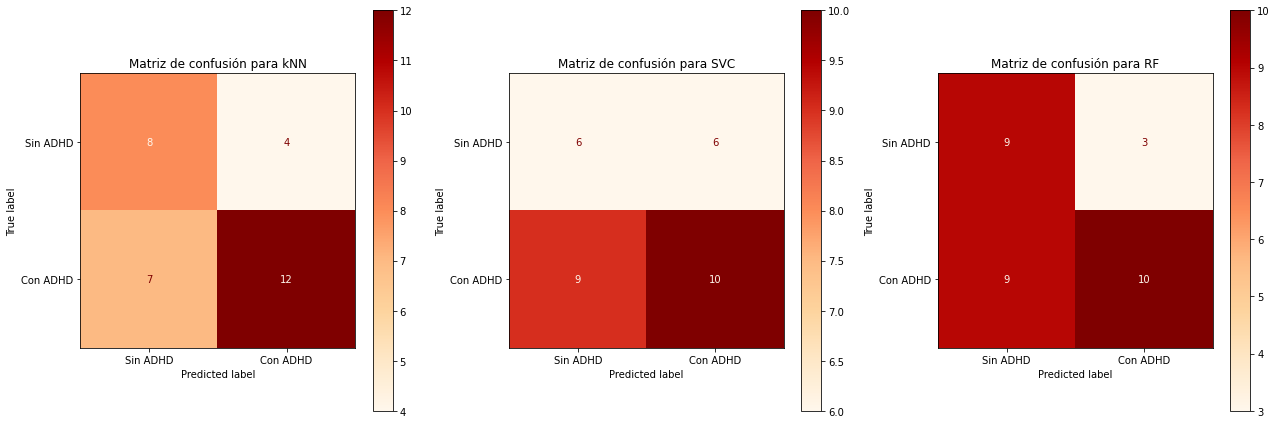

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

disp = plot_confusion_matrix(clf_kNN, X_test, y_test, display_labels=class_names,cmap = 'OrRd', ax=ax1)
disp.ax_.set_title("Matriz de confusión para kNN")

disp = plot_confusion_matrix(clf_SVC, X_test, y_test, display_labels=class_names, cmap = 'OrRd', ax=ax2)
disp.ax_.set_title("Matriz de confusión para SVC")

disp = plot_confusion_matrix(clf_RF, X_test, y_test, display_labels=class_names, cmap = 'OrRd', ax=ax3)
disp.ax_.set_title("Matriz de confusión para RF")

plt.tight_layout() 
plt.show()

In [ ]:
print('\n kNN REPORT')
print(classification_report(y_test, y_pred_kNN, target_names=class_names))
print('\n SVM REPORT')
print(classification_report(y_test, y_pred_SVC, target_names=class_names))
print('\n RANDOM FOREST REPORT')
print(classification_report(y_test, y_pred_RF, target_names=class_names))


 kNN REPORT
              precision    recall  f1-score   support

    Sin ADHD       0.53      0.67      0.59        12
    Con ADHD       0.75      0.63      0.69        19

    accuracy                           0.65        31
   macro avg       0.64      0.65      0.64        31
weighted avg       0.67      0.65      0.65        31


 SVM REPORT
              precision    recall  f1-score   support

    Sin ADHD       0.40      0.50      0.44        12
    Con ADHD       0.62      0.53      0.57        19

    accuracy                           0.52        31
   macro avg       0.51      0.51      0.51        31
weighted avg       0.54      0.52      0.52        31


 RANDOM FOREST REPORT
              precision    recall  f1-score   support

    Sin ADHD       0.50      0.75      0.60        12
    Con ADHD       0.77      0.53      0.62        19

    accuracy                           0.61        31
   macro avg       0.63      0.64      0.61        31
weighted avg       0.67  

Al hacer un análisis con mayor profundidad de los resultados, resulta evidente que los modelos no logran distinguir los casos de ADHD. 

Además se puede ver en el gráfico de ROC que las áreas debajo de la curva están relativamente cercanas a 0.5, lo cual equivale a un modelo de predicción aleatorio.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

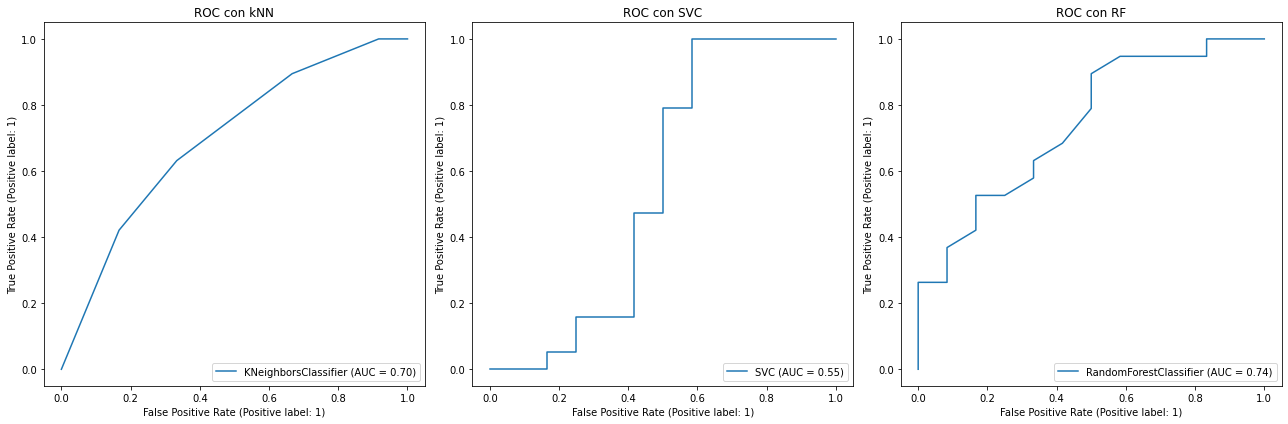

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

metrics.plot_roc_curve(clf_kNN, X_test, y_test, ax=ax1)
ax1.set_title('ROC con kNN') 
metrics.plot_roc_curve(clf_SVC, X_test, y_test, ax=ax2)
ax2.set_title('ROC con SVC') 
metrics.plot_roc_curve(clf_RF, X_test, y_test, ax=ax3) 
ax3.set_title('ROC con RF')

plt.tight_layout() 
plt.show()

## Ajuste de Hiperparámetros

Los resultados vistos hasta recién se obtuvieron con los valores *default* de la biblioteca Scikit-Learn de Python. Para lograr una mejor predicción, se modificará el modelo con distintos parámetros. Inicialmente se utiliza el algoritmo de Randomized Search.



In [ ]:
# Numero de arboles en random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 100, num = 5)]
# Numero de caracteristicas a considerar en cada division
max_features = ['auto', 'sqrt']
# Maxima profundidad del arbol
max_depth = [int(x) for x in np.linspace(60, 600, num = 5)]
max_depth.append(None)
# Minimo numero de muestras requerido para dividir un nodo
min_samples_split = [9, 10, 11]
# Minimo numero de muestras requerido en cada nodo leaf
min_samples_leaf = [1, 2, 3]
# Metodo de seleccion de muestras para el entrenamiento de cada arbol
bootstrap = [True, False]
# Creacion del random grid
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

search2 = RandomizedSearchCV(estimator = clf_RF, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1).fit(X, y)
par2=search2.best_params_
print(par2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 20, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


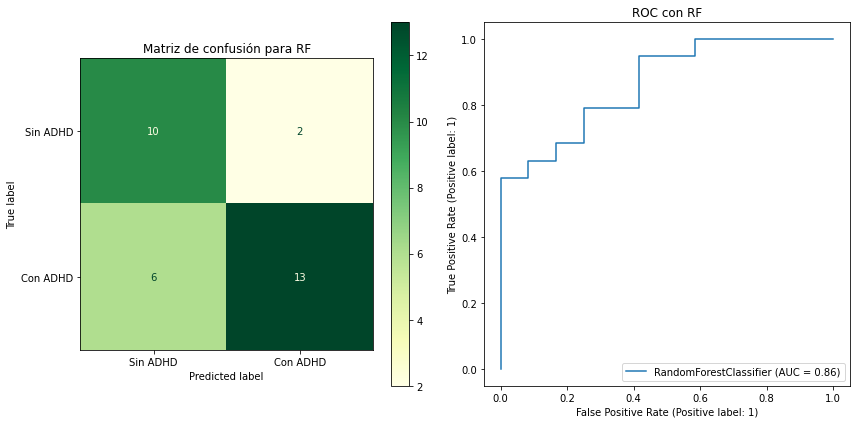


Accuracy para RF: 0.668 (+/- 0.163)

 RANDOM FOREST REPORT
              precision    recall  f1-score   support

    Sin ADHD       0.62      0.83      0.71        12
    Con ADHD       0.87      0.68      0.76        19

    accuracy                           0.74        31
   macro avg       0.75      0.76      0.74        31
weighted avg       0.77      0.74      0.75        31



In [ ]:
clf_RF_new2 = RandomForestClassifier(max_depth=par2["max_depth"], min_samples_split=par2["min_samples_split"], n_estimators=par2['n_estimators'], max_features=par2['max_features'], min_samples_leaf=par2['min_samples_leaf'], bootstrap=par2['bootstrap'], random_state=0)

clf_RF_new2.fit(X_train, y_train)

y_pred_RF_new2 = clf_RF_new2.predict(X_test)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
disp = plot_confusion_matrix(clf_RF_new2, X_test, y_test, display_labels=class_names, cmap = 'YlGn', ax=ax1)
disp.ax_.set_title("Matriz de confusión para RF")

metrics.plot_roc_curve(clf_RF_new2, X_test, y_test, ax=ax2) 
ax2.set_title('ROC con RF')
plt.tight_layout() 
plt.show()

RF_score_cv = cross_val_score(clf_RF_new2, X, y, cv=5)
print("\nAccuracy para RF: %0.3f (+/- %0.3f)" % (RF_score_cv.mean(), RF_score_cv.std() * 2))

print('\n RANDOM FOREST REPORT')
print(classification_report(y_test, y_pred_RF_new2, target_names=class_names))

# Análisis de resultados

Se puede ver en la última sección de resultados que no se logró alcanzar un algoritmo de clasificación de ADHD eficaz. 

A partir de los gráficos de distribución de población y los boxplot de los diferentes parámetros se puede inferir que el problema de clasificación parte de una falta de obtención de un parámetro diferencial que ayude como método de distinción entre los dos grupos. Esto podría estar confundiendo a los algoritmos de aprendizaje automático tanto en el entrenamiento como en el testeo.

Si bien algunos de los valores de media y desvío estándar son acordes a los hallados en investigaciones, estos no son suficientes para poder caracterizar la presencia o ausencia de ADHD con un conocimiento de *Machine Learning* limitado. A su vez la similitud entre los valores de los dos grupos puede deberse a diversos motivos. 

En primer lugar, en cuanto al procesamiento de la señal, al no contar con las señales de EOG se debió recurrir a un método de atenuación de artefactos a través de wavelets. Al ser estimativo, no permite saber con seguridad si se está quitando de forma eficiente ya que no hay una señal con la cual comparar.

Por otro lado, la naturaleza del estudio puede traer sus propios inconvenientes. Si bien se trata de niños entre 7 y 12 años, la tarea de contar figuras presentes en una imagen puede resultar demasiado sencill. Por ese motivo, algunas de las señales duran tan poco como un minuto, aproximadamente. Entonces, es posible que no sea una tarea que requiera demasiada atención y ponga a prueba las características del trastorno. Además se debe tener en cuenta que los niños con ADHD que participaron del estudio se encontraban en tratamiento farmacológico, en algunos casos hasta desde hace 6 meses.

# Referencias


*   Trastorno de déficit de atención con hiperactividad (TDAH) en adultos - Síntomas y causas - Mayo Clinic. (2023). Mayoclinic.org; https://www.mayoclinic.org/es-es/diseases-conditions/adult-adhd/symptoms-causes/syc-20350878#:~:text=El%20trastorno%20por%20d%C3%A9ficit%20de,atenci%C3%B3n%2C%20hiperactividad%20y%20conducta%20impulsiva.
*   Song, P., Zha, M., Yang, Q., Zhang, Y., Li, X., & Rudan, I. (2021). The prevalence of adult attention-deficit hyperactivity disorder: A global systematic review and meta-analysis. Journal of Global Health, 11. https://doi.org/10.7189/jogh.11.04009
* Ali Motie Nasrabadi. (2020, June 10). EEG data for ADHD / Control children. IEEE DataPort. https://ieee-dataport.org/open-access/eeg-data-adhd-control-children
* Cañadas Fragapane, G., Dell'aquila, C., & Leber, E. (n.d.). 58 REVISTA ARGENTINA DE INGENIERÍA -AÑO 6 -VOLUMEN 12 -NOVIEMBRE DE 2018 Proyectos de Desarrollo Tecnológico y Social (PDTS). Retrieved November 28, 2022, from https://ri.conicet.gov.ar/bitstream/handle/11336/156153/CONICET_Digital_Nro.54933a4b-c3fc-4374-a98d-2b6690541cfa_A.pdf?sequence=2&isAllowed=y
* Bajaj, N., Requena Carrión, J., Bellotti, F., Berta, R., & De Gloria, A. (2020). Automatic and tunable algorithm for EEG artifact removal using wavelet decomposition with applications in predictive modeling during auditory tasks. Biomedical Signal Processing and Control, 55, 101624. https://doi.org/10.1016/j.bspc.2019.101624
* Ana Ortiz Pérez, & Inmaculada Moreno García. (2015). Perfil electroencefalográfico de niños con TDAH. Revista de Psicología Clínica Con Niños Y Adolescentes, 2(2), 129–134. https://dialnet.unirioja.es/descarga/articulo/5150427.pdf
* Lenartowicz, A., & Loo, S. K. (2014). Use of EEG to Diagnose ADHD. Current Psychiatry Reports, 16(11). https://doi.org/10.1007/s11920-014-0498-0
* DAWI, N. M., KUCA, K., KREJCAR, O., & NAMAZI, H. (2021). COMPLEXITY AND MEMORY-BASED COMPARISON OF THE BRAIN ACTIVITY BETWEEN ADHD AND HEALTHY SUBJECTS WHILE PLAYING A SERIOUS GAME. Fractals, 29(05), 2150202. https://doi.org/10.1142/s0218348x21502029
* Yentes, J. M., Hunt, N., Schmid, K. K., Kaipust, J. P., McGrath, D., & Stergiou, N. (2012). The Appropriate Use of Approximate Entropy and Sample Entropy with Short Data Sets. Annals of Biomedical Engineering, 41(2), 349–365. https://doi.org/10.1007/s10439-012-0668-3
* Boroujeni, Y. K., Rastegari, A. A., & Khodadadi, H. (2019). Diagnosis of attention deficit hyperactivity disorder using non‐linear analysis of the EEG signal. IET Systems Biology, 13(5), 260–266. https://doi.org/10.1049/iet-syb.2018.5130

